In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import os
import tempfile
import matplotlib.pyplot as plt
from scipy.stats import boxcox, skew, kurtosis, yeojohnson
from statsmodels.graphics.gofplots import qqplot
from sklearn.model_selection import cross_val_score,train_test_split,GridSearchCV,StratifiedKFold
from sklearn.metrics import accuracy_score, log_loss, roc_curve, f1_score, fbeta_score, precision_score, recall_score, confusion_matrix, roc_auc_score, make_scorer
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.combine import SMOTETomek
from imblearn.pipeline import make_pipeline, Pipeline
from prettytable import PrettyTable
import time
import sqlite3
%matplotlib inline
import warnings;
warnings.filterwarnings('ignore');

### Functions

In [85]:
#Plotting functions
def plot_var(df, title):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
    print(f' Skew = {skew(df)}')
    print(f' Kurtosis = {kurtosis(df)}')
    fig.tight_layout()
    fig.subplots_adjust(hspace=.25, wspace=.25)
    sns.set_theme(style="white")
    sns.set_context('poster',font_scale=1)
    g = sns.distplot(df, ax=ax[0])
    g.set_xlabel(title)
    f = qqplot(df, line='s', ax=ax[1]) 
    
def trans_var(df, title, transform=None):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
    fig.tight_layout()
    fig.subplots_adjust(hspace=.25, wspace=.25)
    sns.set_theme(style="white")
    sns.set_context('poster',font_scale=1)
    if transform == None:
        g = sns.distplot(df, ax=ax[0])
        g.set_xlabel(title)
        f = qqplot(df, line='s', ax=ax[1])
        print(f' Skew = {skew(df)}')
        print(f' Kurtosis = {kurtosis(df)}')
    elif transform == boxcox or transform == yeojohnson:
        g = sns.distplot(transform(df)[0], ax=ax[0])
        g.set_xlabel(title)
        f = qqplot(transform(df)[0], line='s', ax=ax[1])
        print(f' Skew = {skew(transform(df)[0])}')
        print(f' Kurtosis = {kurtosis(transform(df)[0])}')
    else:
        g = sns.distplot(transform(df), ax=ax[0])
        g.set_xlabel(title)
        f = qqplot(transform(df), line='s', ax=ax[1])
        print(f' Skew = {skew(transform(df))}')
        print(f' Kurtosis = {kurtosis(transform(df))}')
        
def sigmoid(x):    
    return 1 / (1 + np.exp(-x))

def con_matrix(test, pred, title=None, name=None):
    fig, ax = plt.subplots()
    fig.set_size_inches(11.7, 8.27)
    sns.set_context('poster',font_scale=1.25)
    fig.tight_layout()
    plt.title(title)
    g = sns.heatmap(confusion_matrix(test, pred), cmap=plt.cm.Blues, annot=True, square=True, cbar_kws=dict(shrink=.75), fmt='g',
            xticklabels=['Not Ransomware','Ransomware'], yticklabels=['Not Ransomware','Ransomware'])
    plt.yticks(verticalalignment='center')
    plt.xticks(horizontalalignment='center')
    plt.xlabel('Predicted Value')
    plt.ylabel('Actual Value')
    plt.savefig(f'{name}.png');
    plt.show();
    
def roc(X_test,y_test, model, name=None):
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
    fig, ax = plt.subplots()
    fig.tight_layout()
    fig.set_size_inches(11.7, 8.27)
    sns.set_context('poster',font_scale=1.25)
    plt.plot(fpr, tpr, lw=2)
    plt.plot([0,1],[0,1],c='violet',ls='--')
    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(name)
    plt.text(.2, 0, f'ROC AUC score = {roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]):.3f}', horizontalalignment='left', size='small', color='black');
    plt.savefig(f'{name}.png');
    plt.show();
    
def feature_imp(model, df, name):  
    fig, ax = plt.subplots()
    fig.tight_layout()
    fig.set_size_inches(11.7, 8.27)
    sns.set_context('poster',font_scale=1.25)
    coef = np.abs(model.coef_[0])
    sorted_indices = np.argsort(coef)
    num_features = [i for i in range(df.shape[1])]
    columns = [df.columns[i] for i in sorted_indices]
    plt.barh(num_features, coef[sorted_indices]);
    plt.yticks(num_features, columns);
    plt.title(f'{name}')
    plt.xlabel('Importance')
    plt.ylabel('Features')
    
def plot_loss(history, label, n):
    plt.tight_layout()
    plt.figure(figsize=(20, 15))
    plt.semilogy(history.epoch, history.history['loss'], color='blue',
                 label='Train ' + label)
    plt.semilogy(history.epoch, history.history['val_loss'], color='orange',
                 label='Val ' + label,
                 linestyle="--")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
def plot_metrics(history, title=None):
    fig, ax = plt.subplots()
    fig.tight_layout()
    sns.set_context('poster',font_scale=1.25)
    fig.set_size_inches(27, 20)
    fig.suptitle('Training History', fontsize=40, y=.95)
    #fig.subplots_adjust(hspace=.25, wspace=.25)
    metrics = ['loss', 'auc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric],label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

        plt.legend()
    plt.savefig(f'{title}.png');
    plt.show();
    
def make_table(name, y_true, y_pred, y_prob=None, model=None):
    if model is None:
        if y_prob is None:
            y_prob = np.linspace(.5,.5,len(y_true))
        table = PrettyTable()
        table.field_names = ['Model Name','Accuracy','F1-Score','F2-Score','Precision','Recall','Log-loss','ROC_AUC']
        table.add_row([
        f'{name}',
        '{:.3f}'.format(accuracy_score(y_true, y_pred)),
        '{:.3f}'.format(f1_score(y_true, y_pred)),
        '{:.3f}'.format(fbeta_score(y_true, y_pred, beta=2, average='binary')),
        '{:.3f}'.format(precision_score(y_true, y_pred)),
        '{:.3f}'.format(recall_score(y_true, y_pred)),
        '{:.3f}'.format(log_loss(y_true, y_pred)),
        '{:.3f}'.format(roc_auc_score(y_true, y_prob, average='weighted'))
        ])
        print(table)
    elif model is not None:
        table = PrettyTable()
        table.field_names = ['Model Name','Accuracy','F1-Score','F2-Score','Precision','Recall','Log-loss','ROC_AUC']
        table.add_row([
        f'{name}',
        '{:.3f}'.format(model.history['accuracy'][-1]),
        '{:.3f}'.format(model.history['F1'][-1][0]),
        '{:.3f}'.format(model.history['F2'][-1][0]),
        '{:.3f}'.format(model.history['precision'][-1]),
        '{:.3f}'.format(model.history['recall'][-1]),
        '{:.3f}'.format(log_loss(y_true, y_pred)),
        '{:.3f}'.format(model.history['auc'][-1])
        ])
        print(table)

def analyze(model, X, y, scoring):
# Store the model scores    
    scores = model.cv_results_
# Set up the figure
    fig, ax = plt.subplots(3,2)
    fig.set_size_inches(40, 20)
    sns.set_style('white')
    sns.set_context('poster',font_scale=1.5)
    sns.despine()
    
def model(model, params, scoring=None, refit=False):

# Initialize the transformers
    scaler = StandardScaler()
    smotetomek = SMOTETomek()
    transformer = Pipeline([('standardize', StandardScaler()),
                            ('scale', scaler),
                            ('sampling', smotetomek),
#                             ('dim_reduct', SVD),
                            ('model', model)
                           ])
    
# Set the Cross Validation
    skf = StratifiedKFold(n_splits=5, shuffle=True)

        
# Grid search
    GS = GridSearchCV(transformer, param_grid=params, cv=skf, n_jobs=-1, scoring=scoring, verbose=2, return_train_score=True, error_score='raise', refit=refit)
    return GS

def scale_data(datasets):
    from sklearn.compose import ColumnTransformer
    results = []
    for i,v in enumerate(datasets):
        columns = v.columns
        ct = ColumnTransformer([
        ('standardize', StandardScaler(), columns)
        ], remainder = 'passthrough')

        fit = ct.fit_transform(v)
        results.append(fit)
    return results

In [3]:
conn = sqlite3.connect('../Database/BTC_Data.db')

In [4]:
transactions_df = pd.read_sql_query("""SELECT *
                                    FROM BTC_Transactions
                                    WHERE ROWID IN (SELECT ROWID FROM BTC_Transactions ORDER BY RANDOM()
                                    LIMIT 100000)
                                    AND LENGTH(address) = 34;""", conn)

In [5]:
transactions_df.head()

,address,year,day,length,weight,count,looped,neighbors,income,label
0,1129TSjKtx65E35GiUo4AYVeyo48twbrGX,2016,238,144,0.072848,456,0,1,200000000.0,princetonLocky
1,112wED5uHhY1aiSaWAzgeMDaCKFcCvj9Pn,2016,158,56,0.000031,1,0,1,120000000.0,montrealCryptXXX
2,113bivxFjurkAoWEfVeJ4jawK9fQtn3yRF,2017,21,0,0.500000,1,0,2,99950000.0,princetonCerber
3,114T9gEoJ7G9LGoAL9wDT1nBGGQm3hiSJy,2016,125,0,0.500000,1,0,1,410000000.0,princetonLocky
4,115ncTmF1r86UqNVNiuTbSrg36C9WpbQyg,2016,160,144,0.148449,4309,0,2,119989395.0,montrealCryptXXX


In [6]:
#Check dtypes
transactions_df.dtypes

address       object
year           int64
day            int64
length         int64
weight       float64
count          int64
looped         int64
neighbors      int64
income       float64
label         object
dtype: object

In [7]:
transactions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96207 entries, 0 to 96206
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   address    96207 non-null  object 
 1   year       96207 non-null  int64  
 2   day        96207 non-null  int64  
 3   length     96207 non-null  int64  
 4   weight     96207 non-null  float64
 5   count      96207 non-null  int64  
 6   looped     96207 non-null  int64  
 7   neighbors  96207 non-null  int64  
 8   income     96207 non-null  float64
 9   label      96207 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 7.3+ MB


In [8]:
#Adjust the dytpes and columns
transactions_df['month_day'] = pd.to_datetime(transactions_df['day'], format='%j').dt.strftime('%m-%d')
transactions_df['date'] = pd.to_datetime(transactions_df['month_day'].astype(str)+'-'+transactions_df['year'].astype(str))
transactions_df.drop(columns=['month_day'], inplace=True)
transactions_df['income'] = transactions_df['income'].map('{:.2f}'.format).astype(float)

In [9]:
transactions_df.head()

,address,year,day,length,weight,count,looped,neighbors,income,label,date
0,1129TSjKtx65E35GiUo4AYVeyo48twbrGX,2016,238,144,0.072848,456,0,1,200000000.0,princetonLocky,2016-08-26
1,112wED5uHhY1aiSaWAzgeMDaCKFcCvj9Pn,2016,158,56,0.000031,1,0,1,120000000.0,montrealCryptXXX,2016-06-07
2,113bivxFjurkAoWEfVeJ4jawK9fQtn3yRF,2017,21,0,0.500000,1,0,2,99950000.0,princetonCerber,2017-01-21
3,114T9gEoJ7G9LGoAL9wDT1nBGGQm3hiSJy,2016,125,0,0.500000,1,0,1,410000000.0,princetonLocky,2016-05-05
4,115ncTmF1r86UqNVNiuTbSrg36C9WpbQyg,2016,160,144,0.148449,4309,0,2,119989395.0,montrealCryptXXX,2016-06-09


In [10]:
transactions_df.label.value_counts(normalize=True)

white                          0.977143
paduaCryptoWall                0.006600
princetonCerber                0.005540
montrealCryptoLocker           0.004906
princetonLocky                 0.003607
montrealCryptXXX               0.001341
montrealNoobCrypt              0.000312
montrealDMALocker              0.000197
montrealDMALockerv3            0.000177
montrealSamSam                 0.000042
montrealCryptoTorLocker2015    0.000031
montrealGlobeImposter          0.000021
montrealGlobev3                0.000021
montrealGlobe                  0.000010
montrealAPT                    0.000010
montrealWannaCry               0.000010
montrealEDA2                   0.000010
montrealXLocker                0.000010
montrealCryptConsole           0.000010
Name: label, dtype: float64

In [11]:
#Describe the data
transactions_df.iloc[:,1:7].describe().apply(lambda s: s.apply(lambda x: format(x, '.2f')))

,year,day,length,weight,count,looped
count,96207.00,96207.00,96207.00,96207.00,96207.00,96207.00
mean,2013.97,177.66,41.42,0.54,614.51,199.71
std,2.36,102.84,56.52,4.41,1569.81,888.53
min,2011.00,1.00,0.00,0.00,1.00,0.00
25%,2012.00,89.00,2.00,0.02,1.00,0.00
50%,2014.00,175.00,8.00,0.25,1.00,0.00
75%,2016.00,264.50,72.00,0.75,40.00,0.00
max,2018.00,365.00,144.00,881.48,14494.00,14494.00


In [12]:
#Set up the classes
transactions_df.loc[transactions_df['label'] == 'white', 'class'] = '0'
transactions_df.loc[transactions_df['label'] != 'white', 'class'] = '1'
transactions_df['class'] = transactions_df['class'].astype(int)

In [13]:
transactions_df.dtypes

address              object
year                  int64
day                   int64
length                int64
weight              float64
count                 int64
looped                int64
neighbors             int64
income              float64
label                object
date         datetime64[ns]
class                 int32
dtype: object

In [14]:
#Create a feature of address counts
unique_count_df = pd.DataFrame(transactions_df.address.value_counts()).reset_index()
unique_count_df.rename(columns={'index':'address','address':'add_count'}, inplace=True)
transactions_df = transactions_df.merge(unique_count_df, on='address')

Text(0.5, 1.0, 'Not Ransomware vs Ransomware')

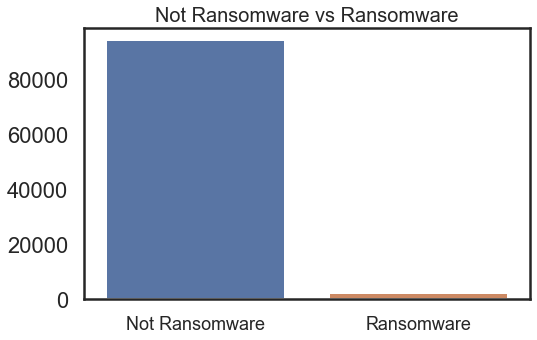

In [15]:
#Check the class imbalance
sns.set_theme(style="white")
sns.set_context('poster',font_scale=1)
plt.figure(figsize=(8,5))
ax = sns.countplot(x="class", data=transactions_df)
ax.set_xticklabels(['Not Ransomware','Ransomware'], fontsize=18)
ax.set_xlabel("")
ax.set_ylabel("")
plt.title('Not Ransomware vs Ransomware', fontsize=20)

In [16]:
transactions_df['class'].value_counts(normalize=True)

0    0.977143
1    0.022857
Name: class, dtype: float64

### Analyze the variables

 Skew = 9.597857022851953
 Kurtosis = 142.86344858102044


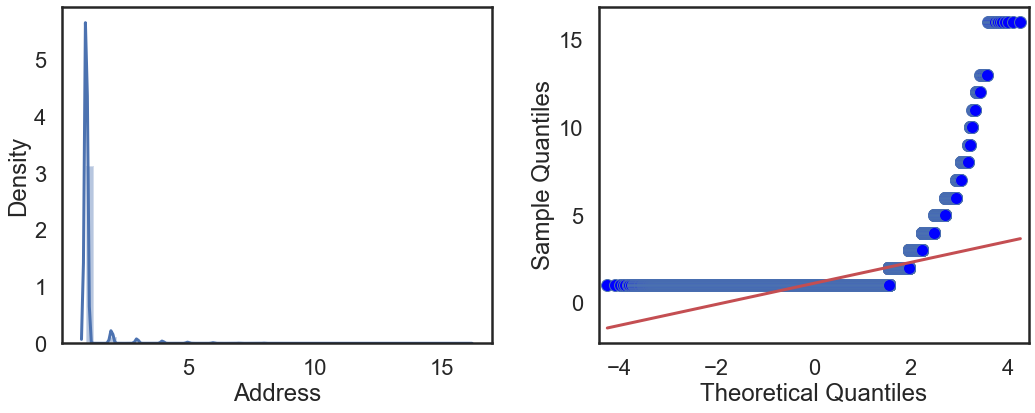

In [17]:
plot_var(transactions_df['add_count'], 'Address')

In [18]:
#Zoom in
address_values = pd.Series(transactions_df.add_count.to_list())
address_values.value_counts(normalize=True)

1     0.939204
2     0.035902
3     0.012224
4     0.006195
5     0.003118
6     0.001684
8     0.000499
7     0.000437
16    0.000166
13    0.000135
12    0.000125
11    0.000114
10    0.000104
9     0.000094
dtype: float64

Most addresses only appear once.

 Skew = 3.6760283091085677
 Kurtosis = 11.513184129613585


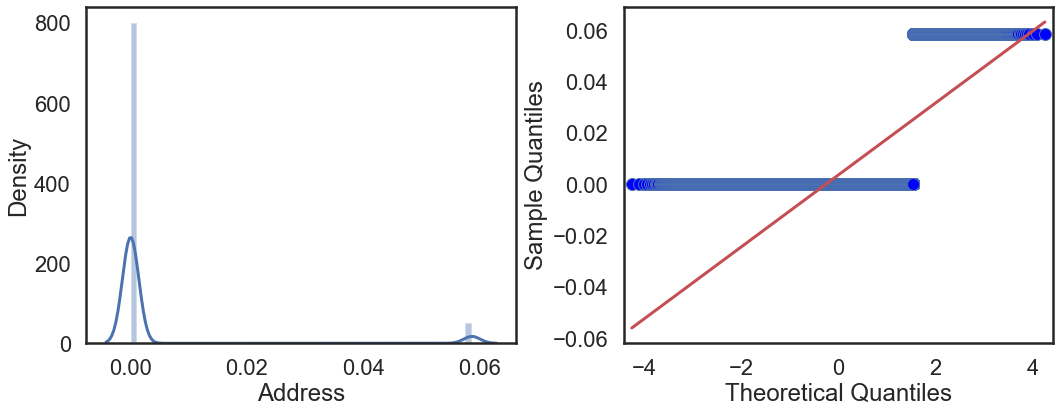

In [19]:
trans_var(transactions_df['add_count'], 'Address', boxcox) #No transform. I added the count of address instead

 Skew = 1.0713445922926148
 Kurtosis = -0.6254713680198378


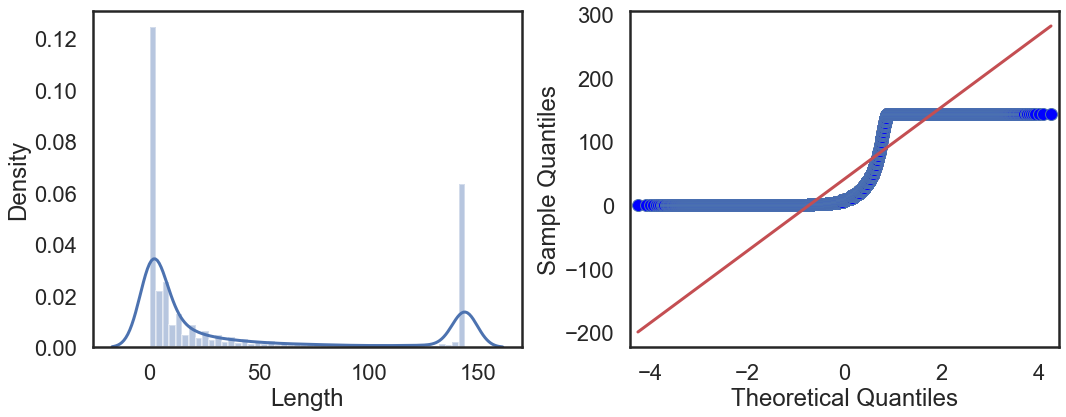

In [20]:
plot_var(transactions_df['length'], 'Length')

 Skew = 0.04178700880666817
 Kurtosis = -1.430181387792096


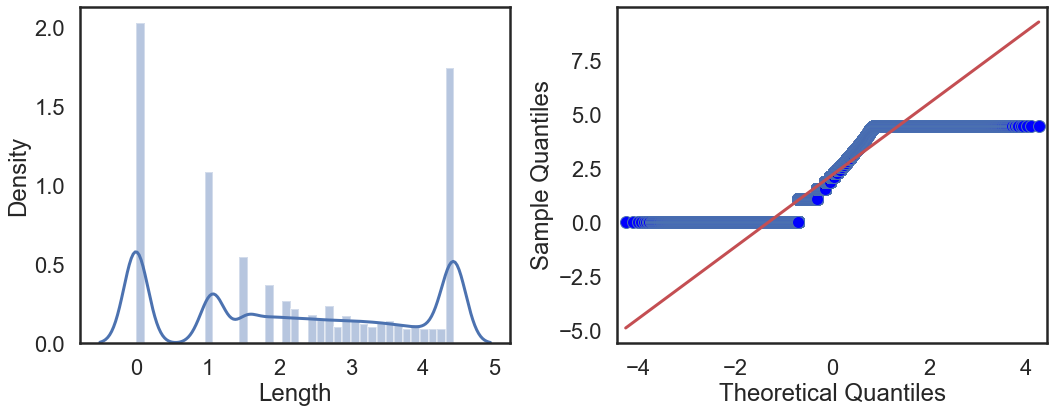

In [21]:
trans_var(transactions_df['length'], 'Length', yeojohnson) #No transform

 Skew = 136.04408274670732
 Kurtosis = 23876.9863359494


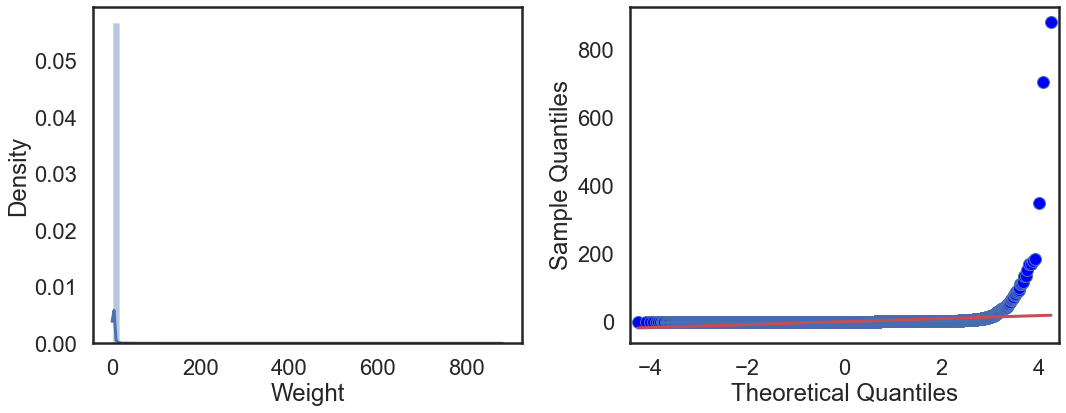

In [22]:
plot_var(transactions_df['weight'], 'Weight')

 Skew = -0.5367325733776437
 Kurtosis = -0.0322437220531242


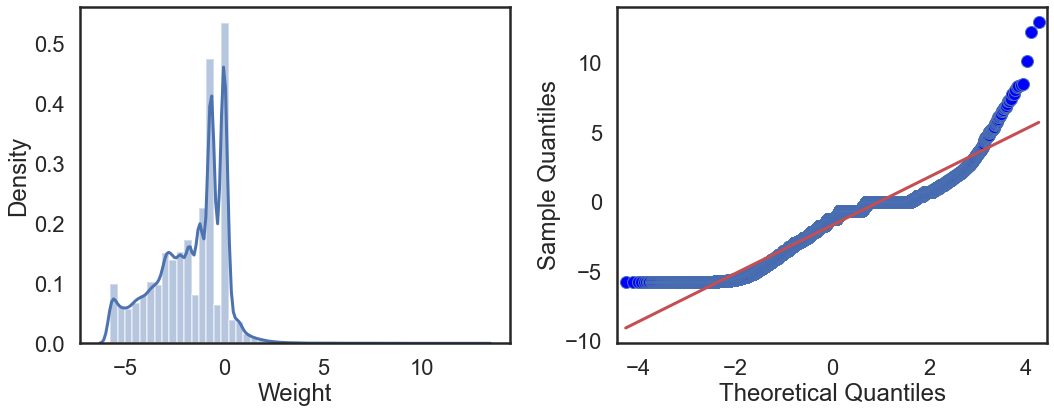

In [23]:
trans_var(transactions_df['weight'], 'Weight', boxcox) #Transform

In [24]:
#Add transformed feature
transactions_df['weight_boxcox'] = pd.Series(boxcox(transactions_df['weight'])[0])

 Skew = 3.2346478785979467
 Kurtosis = 11.597735704953706


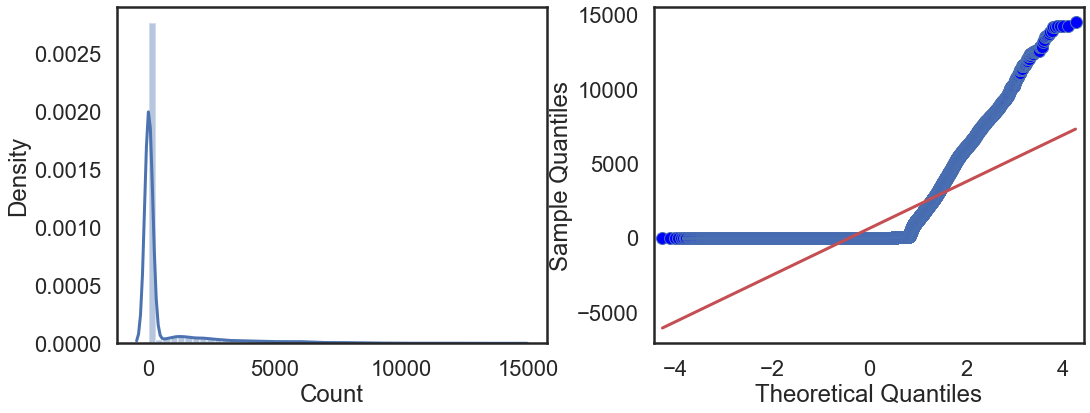

In [25]:
plot_var(transactions_df['count'], 'Count') #No transform

 Skew = 0.7367908183378776
 Kurtosis = -1.2510026184134893


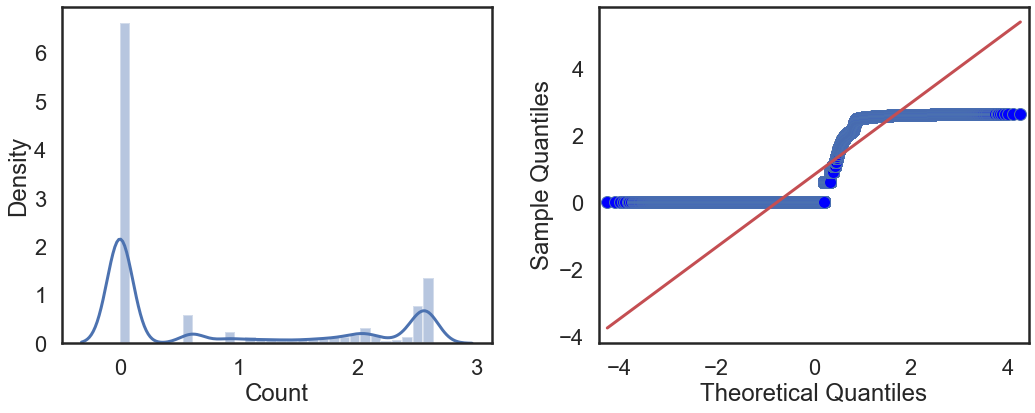

In [26]:
trans_var(transactions_df['count'], 'Count', boxcox) #No transform

 Skew = 6.084082194882367
 Kurtosis = 45.40671389116908


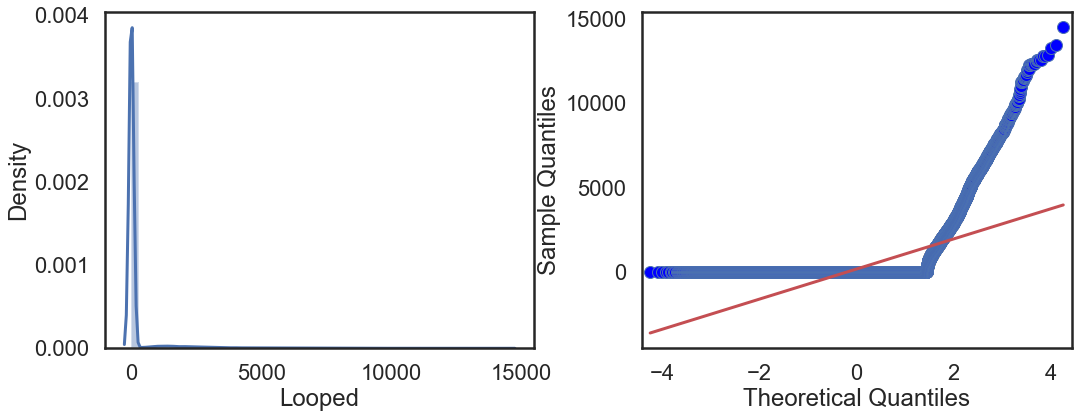

In [27]:
plot_var(transactions_df['looped'], 'Looped')

In [28]:
#Zoom in
looped_values = pd.Series(transactions_df.looped.to_list())
looped_values.value_counts(normalize=True)

0       0.872431
1       0.021225
2       0.005603
3       0.003097
4       0.001850
          ...   
1041    0.000010
3590    0.000010
824     0.000010
2161    0.000010
992     0.000010
Length: 4085, dtype: float64

Most transactions have only 1 path.

 Skew = 2.333852470448455
 Kurtosis = 3.5776232604223184


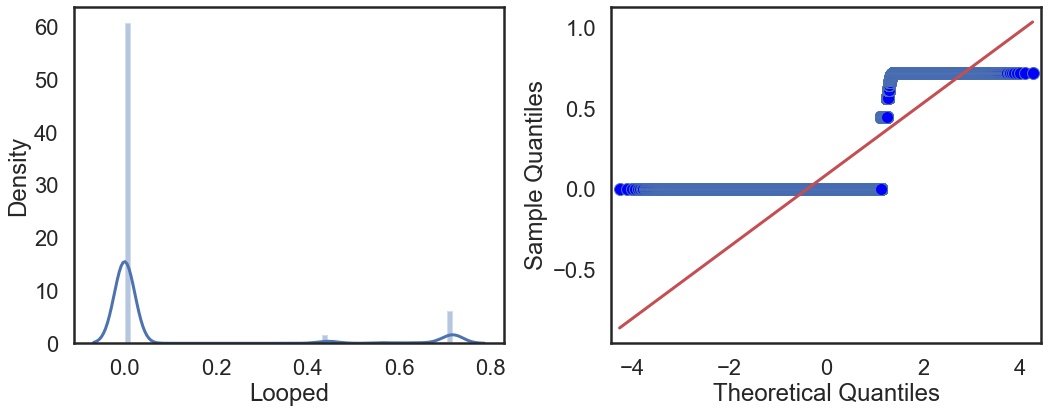

In [29]:
trans_var(transactions_df['looped'], 'Looped', yeojohnson) #No transform

 Skew = 60.73022414113133
 Kurtosis = 4613.707389320413


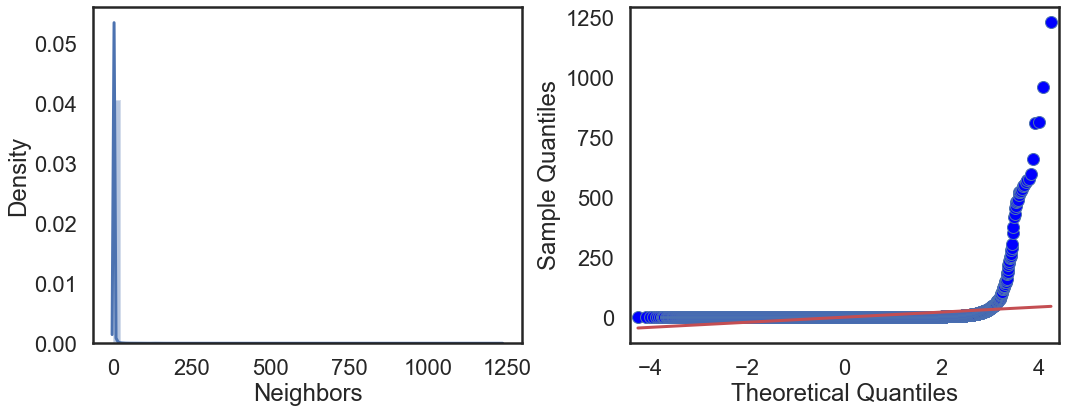

In [30]:
plot_var(transactions_df['neighbors'], 'Neighbors')

In [31]:
#Zoom in
neighbor_values = pd.Series(transactions_df.neighbors.to_list())
neighbor_values.value_counts(normalize=True)

2      0.619310
1      0.325694
4      0.019437
3      0.015477
6      0.004927
         ...   
555    0.000010
489    0.000010
523    0.000010
254    0.000010
522    0.000010
Length: 130, dtype: float64

Most transactions have 1 or 2 neighbors

 Skew = -0.04210637322453557
 Kurtosis = -0.1013150404566292


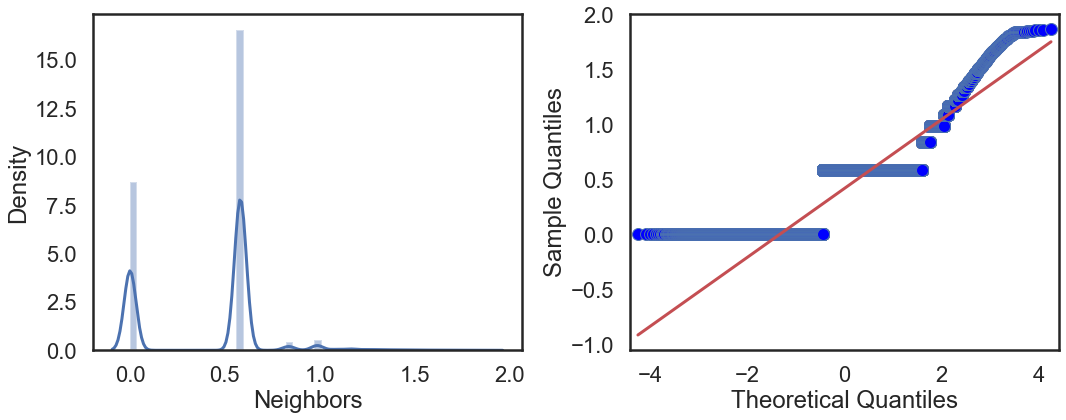

In [32]:
trans_var(transactions_df['neighbors'], 'Neighbors', boxcox) #transform

In [33]:
#Add transformed feature
transactions_df['neighbors_boxcox'] = pd.Series(boxcox(transactions_df['neighbors'])[0])

 Skew = 238.8573636329515
 Kurtosis = 66470.43446824879


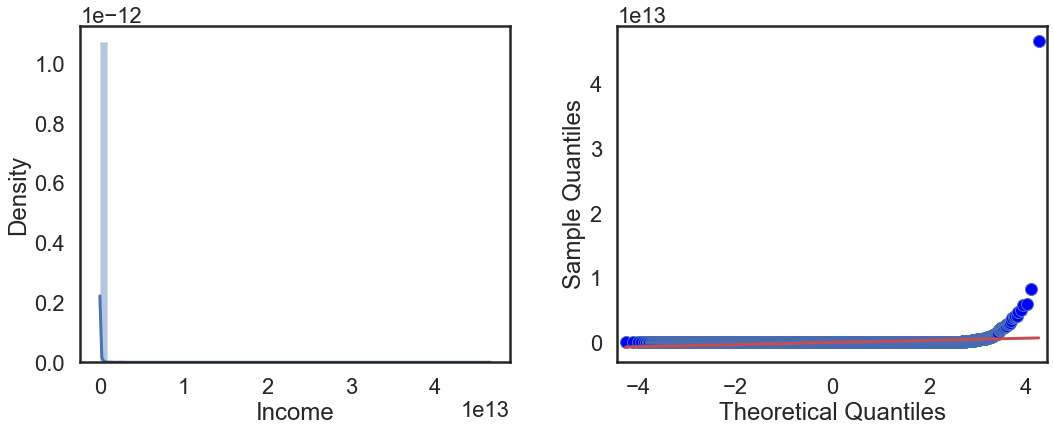

In [34]:
plot_var(transactions_df['income'], 'Income')

 Skew = 0.8307769829495922
 Kurtosis = 0.26262082124098685


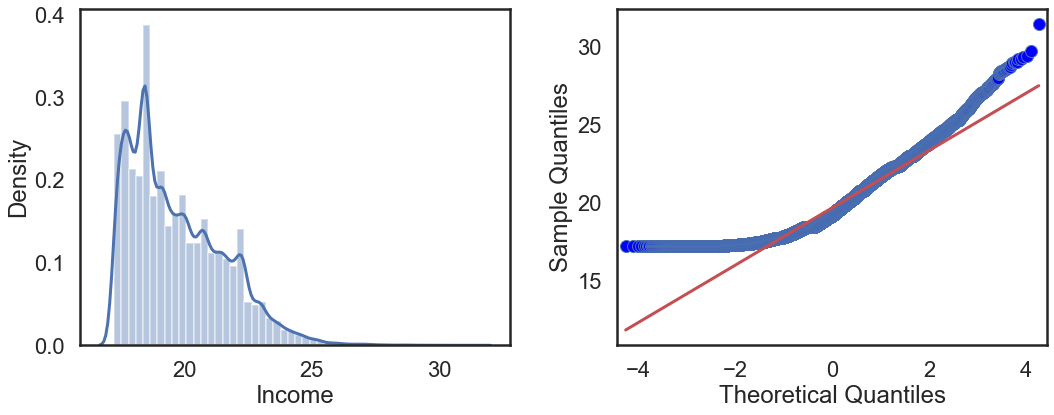

In [35]:
trans_var(transactions_df['income'], 'Income', np.log) #Transform

In [36]:
#Add transformed feature
transactions_df['income_log'] = pd.Series(np.log(transactions_df['income']))

 Skew = 0.062040005418789866
 Kurtosis = -1.1517116495524098


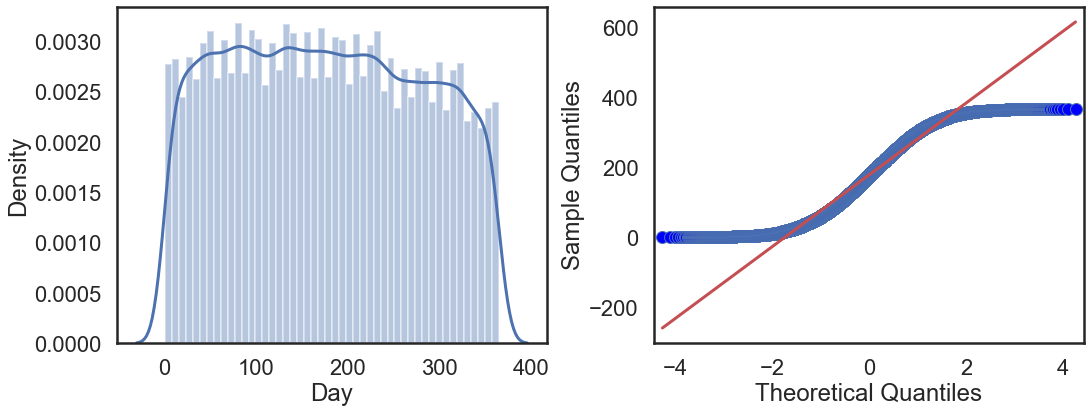

In [37]:
plot_var(transactions_df['day'], 'Day') #Might want to add day of the week or run this alongside bitcoin price/returns

 Skew = -0.2564544564822894
 Kurtosis = -0.973960624609818


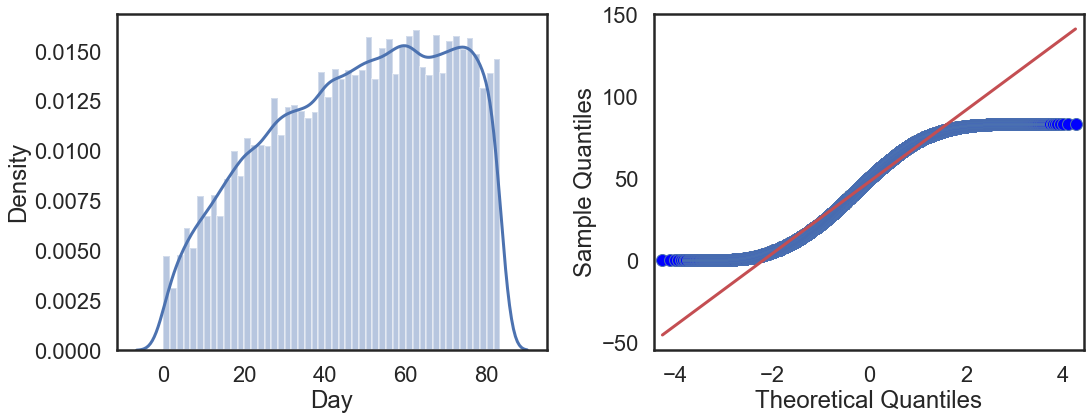

In [38]:
trans_var(transactions_df['day'], 'Day', boxcox) #Does not need a transform

In [39]:
#Add additional feature
transactions_df['day_of_the_week'] = transactions_df['date'].dt.dayofweek
transactions_df['date'] = transactions_df['date'].apply(lambda x: x.toordinal())
transactions_df['day_of_the_week'] = transactions_df['day_of_the_week'].astype('category')

 Skew = 0.2599639570478
 Kurtosis = -1.2779306153571242


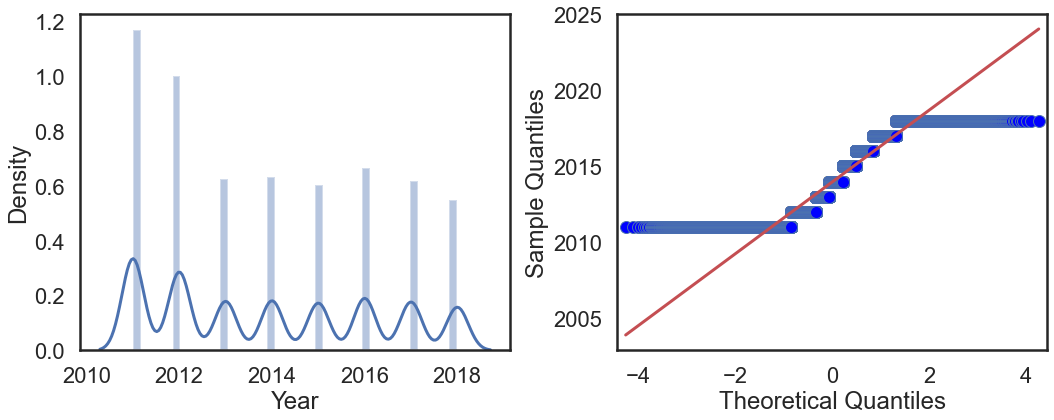

In [40]:
plot_var(transactions_df['year'], 'Year') #Might want to run this against bitcoin prices/returns

 Skew = 0.2588118118093857
 Kurtosis = -1.2787576279676742


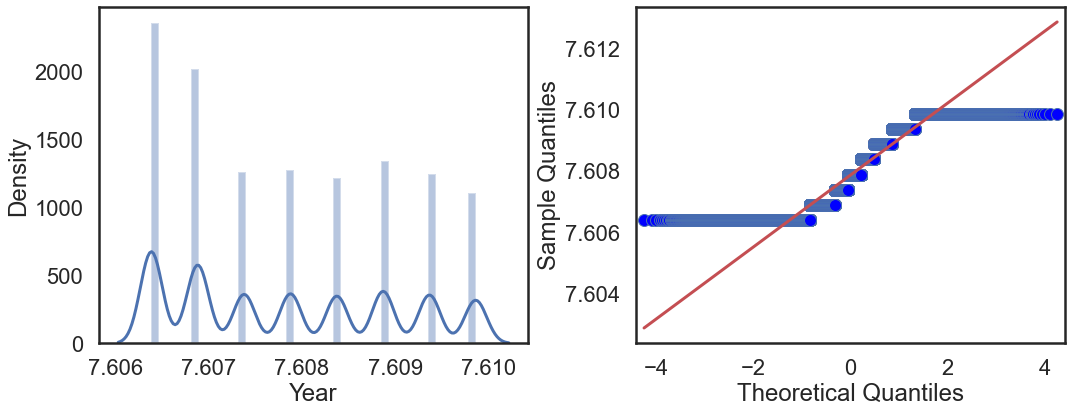

In [41]:
trans_var(transactions_df['year'], 'Year', np.log) #Does not need a transform

In [ ]:
g = sns.pairplot(data=transactions_df, hue='class', diag_kind="hist", size=5)

In [42]:
transactions_df.head(5)

,address,year,day,length,weight,count,looped,neighbors,income,label,date,class,add_count,weight_boxcox,neighbors_boxcox,income_log,day_of_the_week
0,1129TSjKtx65E35GiUo4AYVeyo48twbrGX,2016,238,144,0.072848,456,0,1,200000000.0,princetonLocky,736202,1,1,-2.104067,0.000000,19.113828,4
1,112wED5uHhY1aiSaWAzgeMDaCKFcCvj9Pn,2016,158,56,0.000031,1,0,1,120000000.0,montrealCryptXXX,736122,1,1,-4.808429,0.000000,18.603002,1
2,113bivxFjurkAoWEfVeJ4jawK9fQtn3yRF,2017,21,0,0.500000,1,0,2,99950000.0,princetonCerber,736350,1,1,-0.653012,0.581634,18.420181,5
3,114T9gEoJ7G9LGoAL9wDT1nBGGQm3hiSJy,2016,125,0,0.500000,1,0,1,410000000.0,princetonLocky,736089,1,1,-0.653012,0.000000,19.831668,3
4,115ncTmF1r86UqNVNiuTbSrg36C9WpbQyg,2016,160,144,0.148449,4309,0,2,119989395.0,montrealCryptXXX,736124,1,1,-1.623474,0.581634,18.602914,3


In [43]:
#Reorder columns
transactions_df = transactions_df[['address','label','date','year','day','length','weight','count','looped','neighbors',
                                   'income','add_count','weight_boxcox','neighbors_boxcox','income_log','day_of_the_week','class']]

transactions_df.iloc[:, 2:-1].head(5)


,date,year,day,length,weight,count,looped,neighbors,income,add_count,weight_boxcox,neighbors_boxcox,income_log,day_of_the_week
0,736202,2016,238,144,0.072848,456,0,1,200000000.0,1,-2.104067,0.000000,19.113828,4
1,736122,2016,158,56,0.000031,1,0,1,120000000.0,1,-4.808429,0.000000,18.603002,1
2,736350,2017,21,0,0.500000,1,0,2,99950000.0,1,-0.653012,0.581634,18.420181,5
3,736089,2016,125,0,0.500000,1,0,1,410000000.0,1,-0.653012,0.000000,19.831668,3
4,736124,2016,160,144,0.148449,4309,0,2,119989395.0,1,-1.623474,0.581634,18.602914,3


In [44]:
#Baseline Train and Test
X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(transactions_df[['date','year','day','length','weight','count','looped','neighbors','income','add_count']], 
                                                    transactions_df['class'],
                                                    stratify = transactions_df['class'],
                                                    random_state = 24, 
                                                    test_size = 0.2)


In [45]:
#Feature Engineered Train and Test
X_train_eng, X_test_eng, y_train_eng, y_test_eng = train_test_split(transactions_df[['date','year','day','length','weight','looped','add_count','weight_boxcox','neighbors_boxcox','income_log','day_of_the_week']], 
                                                    transactions_df['class'],
                                                    stratify = transactions_df['class'],
                                                    random_state = 24, 
                                                    test_size = 0.2)


## Baseline - Random Model

In [46]:
#Random model
class RandomModel():
    def predict(self, X):
        #predict class labels randomly
        from tqdm import tqdm
        y_pred = np.array([])
        for data_point in tqdm(range(X.shape[0])):
            if np.random.uniform(0, 1) >= 0.5:
                y_pred = np.append(y_pred, 1)
            else:
                y_pred = np.append(y_pred, 0)
        return y_pred

In [47]:
#Predict Values
random_model = RandomModel()
base_pred = random_model.predict(X_test_base)
eng_pred = random_model.predict(X_test_eng)

100%|██████████| 19242/19242 [00:00<00:00, 48094.41it/s]


In [48]:
make_table("Random Model Base", y_test_base, base_pred)
make_table("Random Model Eng", y_test_eng, eng_pred)

+-------------------+----------+----------+----------+-----------+--------+----------+---------+
|     Model Name    | Accuracy | F1-Score | F2-Score | Precision | Recall | Log-loss | ROC_AUC |
+-------------------+----------+----------+----------+-----------+--------+----------+---------+
| Random Model Base |  0.505   |  0.047   |  0.104   |   0.025   | 0.536  |  17.097  |  0.500  |
+-------------------+----------+----------+----------+-----------+--------+----------+---------+
+------------------+----------+----------+----------+-----------+--------+----------+---------+
|    Model Name    | Accuracy | F1-Score | F2-Score | Precision | Recall | Log-loss | ROC_AUC |
+------------------+----------+----------+----------+-----------+--------+----------+---------+
| Random Model Eng |  0.495   |  0.043   |  0.095   |   0.022   | 0.493  |  17.455  |  0.500  |
+------------------+----------+----------+----------+-----------+--------+----------+---------+


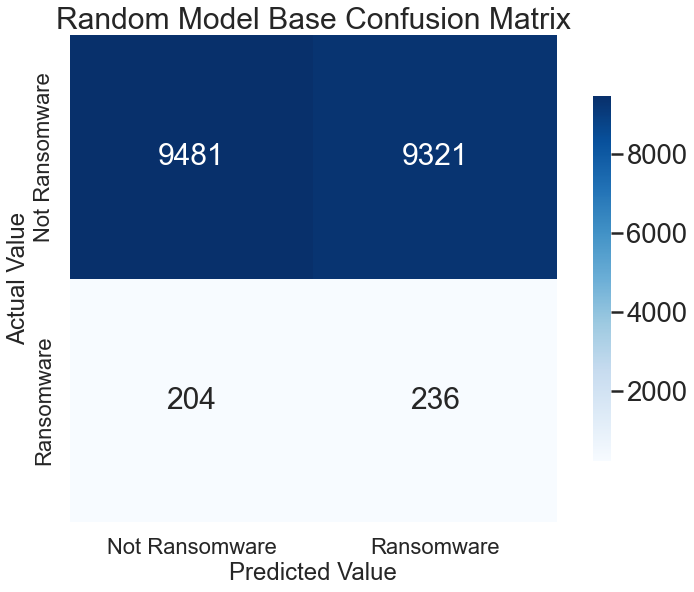

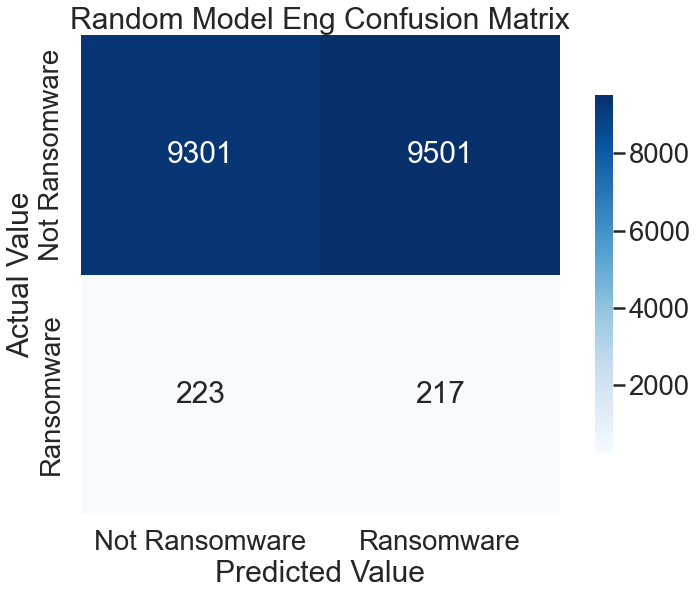

In [49]:
#Confusion matrix
con_matrix(y_test_base, base_pred, 'Random Model Base Confusion Matrix', name='Random_Model_Base_CM')
con_matrix(y_test_eng, eng_pred, 'Random Model Eng Confusion Matrix', name='Random_Model_Eng_CM')

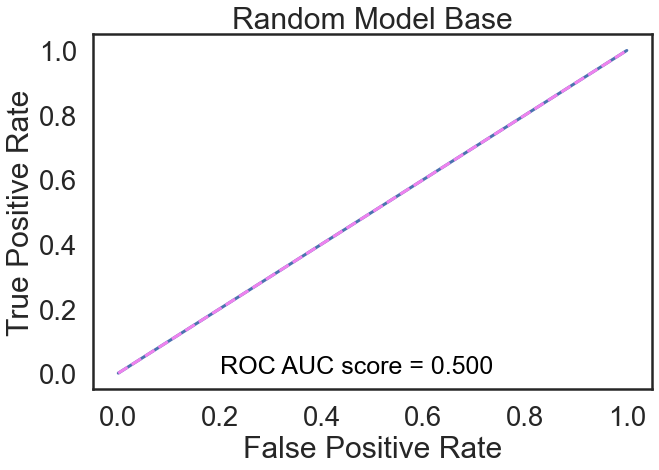

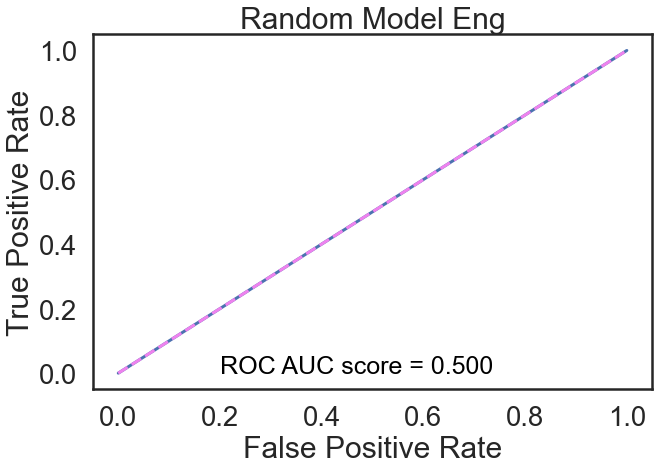

In [50]:
results = base_pred, eng_pred
name = ['Base','Eng']
for i,v in enumerate(results):
    fig, ax = plt.subplots()
    fig.tight_layout()
    fig.set_size_inches(11.7, 8.27)
    sns.set_context('poster',font_scale=1.25)
    plt.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), label='Random Model (AUC = 0.500)')
    plt.plot([0,1],[0,1],c='violet',ls='--')
    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Random Model {name[i]}')
    ROC_AUC_score = '{:.3f}'.format(roc_auc_score(y_true = v, y_score = np.linspace(.5,.5,len(y_test_base)), average='weighted'))
    plt.text(.2, 0, f'ROC AUC score = {ROC_AUC_score}', horizontalalignment='left', size='small', color='black');
    plt.show()

## Logistic Regression

In [51]:
from sklearn.linear_model import SGDClassifier

# Initialize the model
SGDC_model = SGDClassifier(random_state = 24)

# Set the parameters
params = {
    'model__loss':['modified_huber','log'],
    'model__penalty':['l1','l2','elasticnet'],
    'model__alpha': 10.0**-np.arange(1,7),
    'model__shuffle': [True],
    'model__learning_rate': ['optimal','invscaling','adaptive'],
    'model__eta0': [.01],
    'model__max_iter': [100],
    'model__early_stopping': [False],
#     'model__validation_fraction': [.2],
    'model__class_weight': ['balanced'],
#     'model__warm_start': [True]
    }

# Set the scoring

scoring = {
           'Accuracy':make_scorer(accuracy_score),
#            'Brier Score':make_scorer(brier_score_loss), 
           'Average Precision':make_scorer(precision_score, average='weighted'),
           'F2 Score':make_scorer(fbeta_score, beta=2, average='binary'),
           'F1 Score':make_scorer(f1_score),
           'Recall':make_scorer(recall_score),
           'Log Loss':make_scorer(log_loss),
           'ROC_AUC':make_scorer(roc_auc_score, average='weighted')
            }

# Training config

skf = StratifiedKFold(n_splits=5, shuffle=True)

refit = 'F2 Score'


SGDC_model_base = model(SGDC_model, params, scoring=scoring, refit=refit)
SGDC_model_eng = model(SGDC_model, params, scoring=scoring, refit=refit)

In [52]:
# Fit Model
SGDC_model_base.fit(X_train_base, y_train_base)
print(SGDC_model_base.best_params_)

SGDC_model_eng.fit(X_train_eng, y_train_eng)
print(SGDC_model_eng.best_params_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'model__alpha': 0.01, 'model__class_weight': 'balanced', 'model__early_stopping': False, 'model__eta0': 0.01, 'model__learning_rate': 'adaptive', 'model__loss': 'log', 'model__max_iter': 100, 'model__penalty': 'elasticnet', 'model__shuffle': True}
Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'model__alpha': 0.1, 'model__class_weight': 'balanced', 'model__early_stopping': False, 'model__eta0': 0.01, 'model__learning_rate': 'adaptive', 'model__loss': 'modified_huber', 'model__max_iter': 100, 'model__penalty': 'l1', 'model__shuffle': True}


In [53]:
make_table("Logistic Regression Base", y_test_base, SGDC_model_base.predict(X_test_base), SGDC_model_base.predict_proba(X_test_base)[:, 1])
make_table("Logistic Regression Eng", y_test_eng, SGDC_model_eng.predict(X_test_eng), SGDC_model_eng.predict_proba(X_test_eng)[:, 1])

+--------------------------+----------+----------+----------+-----------+--------+----------+---------+
|        Model Name        | Accuracy | F1-Score | F2-Score | Precision | Recall | Log-loss | ROC_AUC |
+--------------------------+----------+----------+----------+-----------+--------+----------+---------+
| Logistic Regression Base |  0.687   |  0.102   |  0.212   |   0.054   | 0.773  |  10.799  |  0.763  |
+--------------------------+----------+----------+----------+-----------+--------+----------+---------+
+-------------------------+----------+----------+----------+-----------+--------+----------+---------+
|        Model Name       | Accuracy | F1-Score | F2-Score | Precision | Recall | Log-loss | ROC_AUC |
+-------------------------+----------+----------+----------+-----------+--------+----------+---------+
| Logistic Regression Eng |  0.696   |  0.095   |  0.198   |   0.051   | 0.700  |  10.517  |  0.773  |
+-------------------------+----------+----------+----------+--------

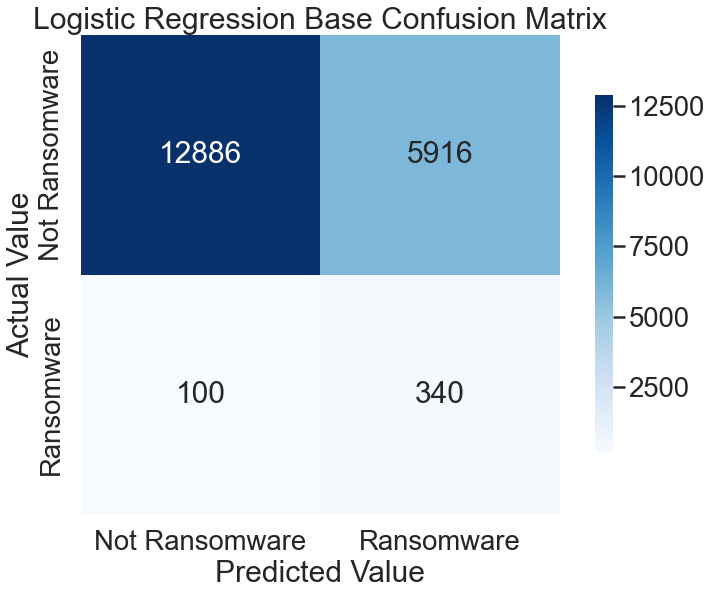

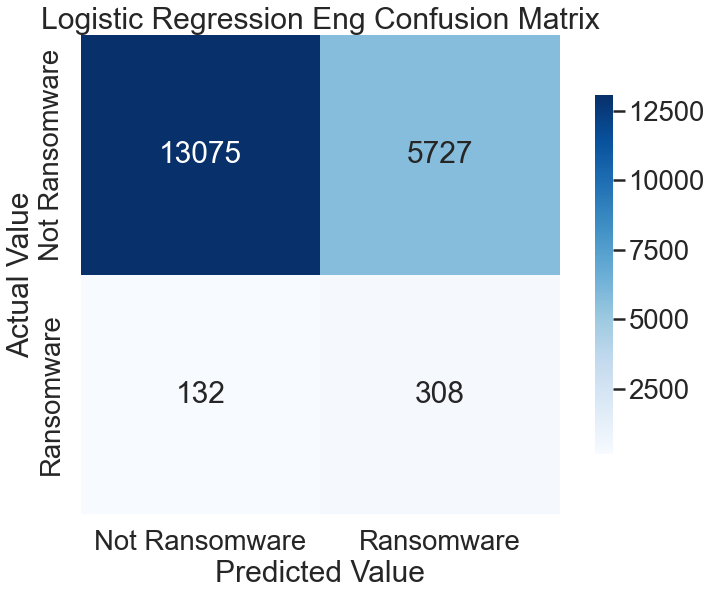

In [100]:
con_matrix(y_test_base, SGDC_model_base.predict(X_test_base), 'Logistic Regression Base Confusion Matrix', name='Logistic_Regression_Base_CM')
con_matrix(y_test_eng, SGDC_model_eng.predict(X_test_eng), 'Logistic Regression Eng Confusion Matrix', name='Logistic_Regression_Eng_CM')

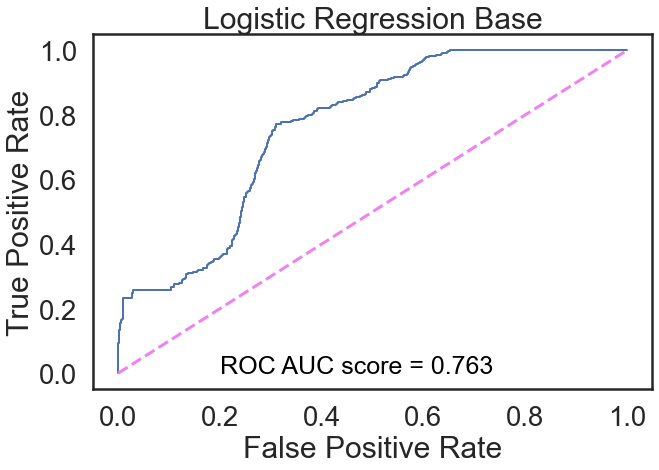

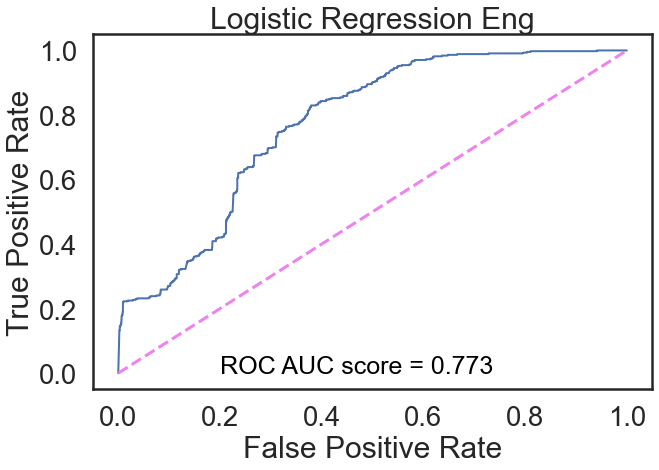

In [55]:
roc(X_test_base, y_test_base, SGDC_model_base, "Logistic Regression Base")
roc(X_test_eng, y_test_eng, SGDC_model_eng, "Logistic Regression Eng")

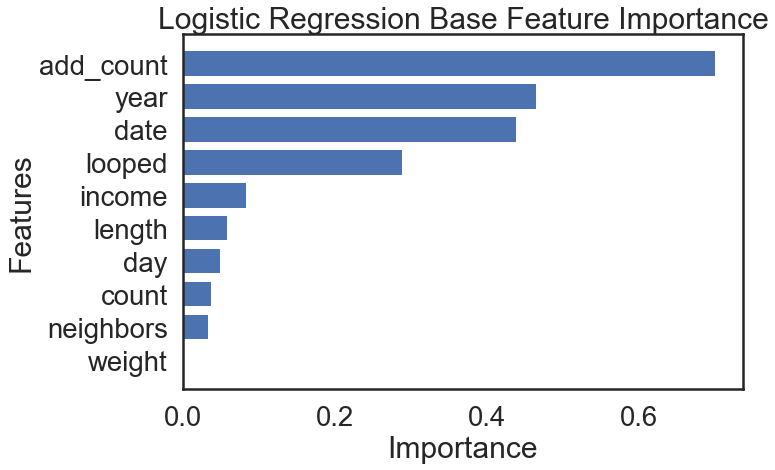

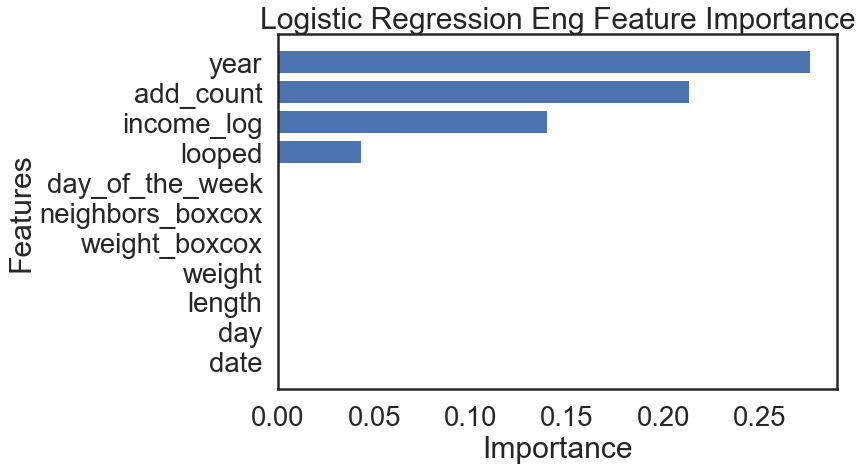

In [56]:
#Feature importance chart
feature_imp(SGDC_model_base.best_estimator_[-1], X_train_base, "Logistic Regression Base Feature Importance")
feature_imp(SGDC_model_eng.best_estimator_[-1], X_train_eng, "Logistic Regression Eng Feature Importance")

## Random Forest

In [57]:
from sklearn.ensemble import RandomForestClassifier

RF_model = RandomForestClassifier()

params = {
    'model__n_estimators':[1, 10, 20],
    'model__criterion':['gini', 'entropy'],
    'model__max_depth':[None],
    'model__max_features':['sqrt'],
    'model__min_samples_split':[2],
    'model__bootstrap':[True],
    'model__oob_score':[True],
    'model__class_weight':['balanced', 'balanced_subsample']
}

scoring = {
           'Accuracy':make_scorer(accuracy_score),
#            'Brier Score':make_scorer(brier_score_loss), 
           'Average Precision':make_scorer(precision_score, average='weighted'),
           'F2 Score':make_scorer(fbeta_score, beta=2, average='binary'),
           'F1 Score':make_scorer(f1_score),
           'Recall':make_scorer(recall_score),
           'Log Loss':make_scorer(log_loss),
           'ROC_AUC':make_scorer(roc_auc_score, average='weighted')
            }

# Training config

skf = StratifiedKFold(n_splits=5, shuffle=True)

refit = 'F2 Score'

RF_model_base = model(RF_model, params, scoring=scoring, refit=refit)
RF_model_eng = model(RF_model, params, scoring=scoring, refit=refit)

In [58]:
# Fit Model
RF_model_base.fit(X_train_base, y_train_base)
print(RF_model_base.best_params_)

RF_model_eng.fit(X_train_eng, y_train_eng)
print(RF_model_eng.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
{'model__bootstrap': True, 'model__class_weight': 'balanced', 'model__criterion': 'entropy', 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_split': 2, 'model__n_estimators': 20, 'model__oob_score': True}
Fitting 5 folds for each of 12 candidates, totalling 60 fits
{'model__bootstrap': True, 'model__class_weight': 'balanced', 'model__criterion': 'entropy', 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_split': 2, 'model__n_estimators': 20, 'model__oob_score': True}


In [59]:
make_table("Random Forest Base", y_test_base, RF_model_base.predict(X_test_base), RF_model_base.predict_proba(X_test_base)[:, 1])
make_table("Random Forest Eng", y_test_eng, RF_model_eng.predict(X_test_eng), RF_model_eng.predict_proba(X_test_eng)[:, 1])

+--------------------+----------+----------+----------+-----------+--------+----------+---------+
|     Model Name     | Accuracy | F1-Score | F2-Score | Precision | Recall | Log-loss | ROC_AUC |
+--------------------+----------+----------+----------+-----------+--------+----------+---------+
| Random Forest Base |  0.975   |  0.520   |  0.560   |   0.464   | 0.591  |  0.862   |  0.934  |
+--------------------+----------+----------+----------+-----------+--------+----------+---------+
+-------------------+----------+----------+----------+-----------+--------+----------+---------+
|     Model Name    | Accuracy | F1-Score | F2-Score | Precision | Recall | Log-loss | ROC_AUC |
+-------------------+----------+----------+----------+-----------+--------+----------+---------+
| Random Forest Eng |  0.977   |  0.545   |  0.575   |   0.500   | 0.598  |  0.790   |  0.931  |
+-------------------+----------+----------+----------+-----------+--------+----------+---------+


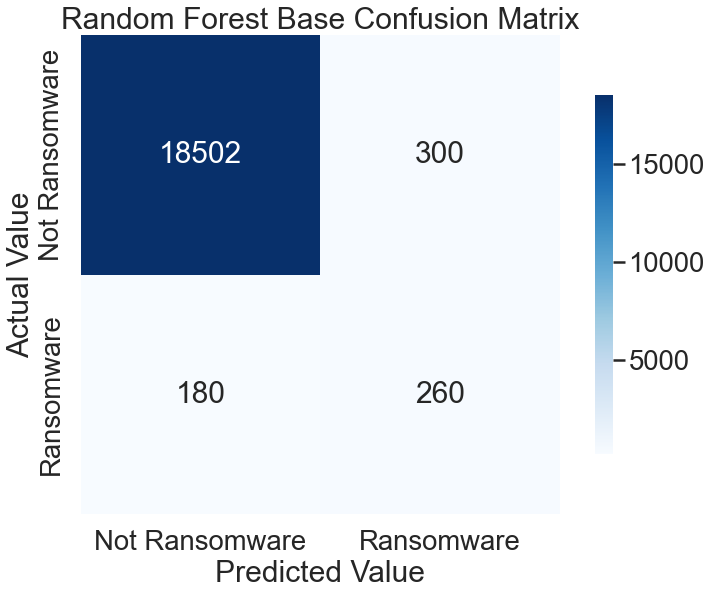

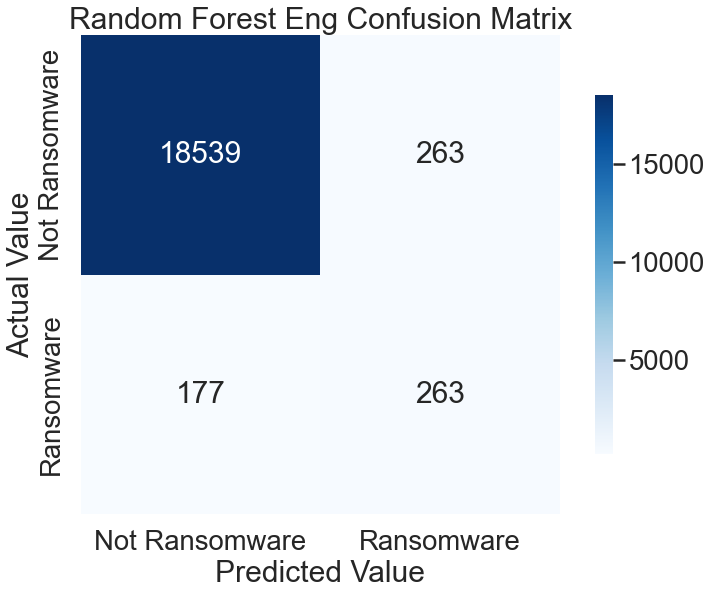

In [99]:
con_matrix(y_test_base, RF_model_base.predict(X_test_base), 'Random Forest Base Confusion Matrix', name='Random_Forest_Base_CM')
con_matrix(y_test_eng, RF_model_eng.predict(X_test_eng), 'Random Forest Eng Confusion Matrix', name='Random_Forest_Eng_CM')

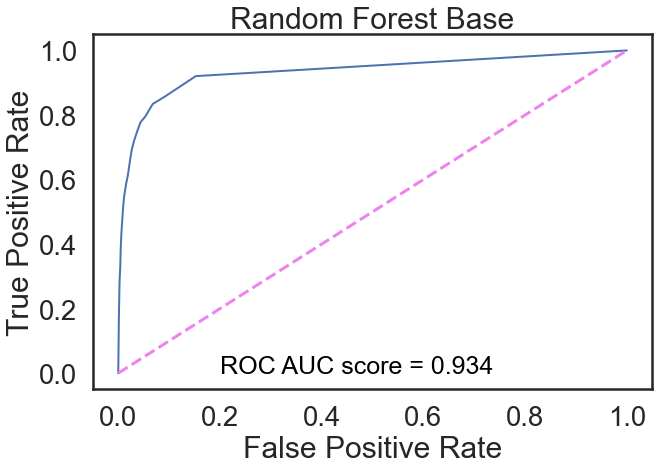

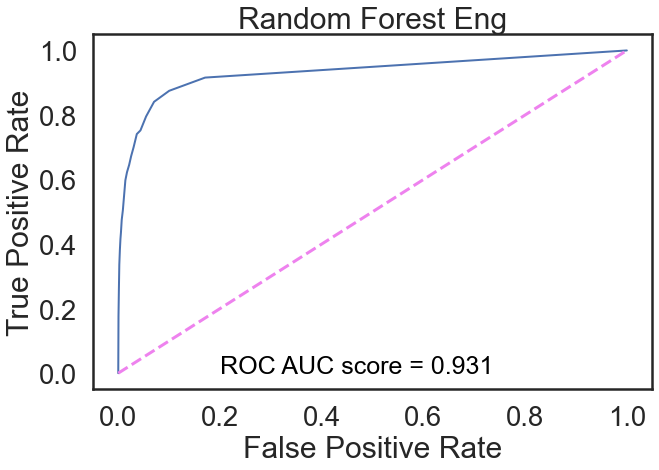

In [61]:
roc(X_test_base, y_test_base, RF_model_base, "Random Forest Base")
roc(X_test_eng, y_test_eng, RF_model_eng, "Random Forest Eng")

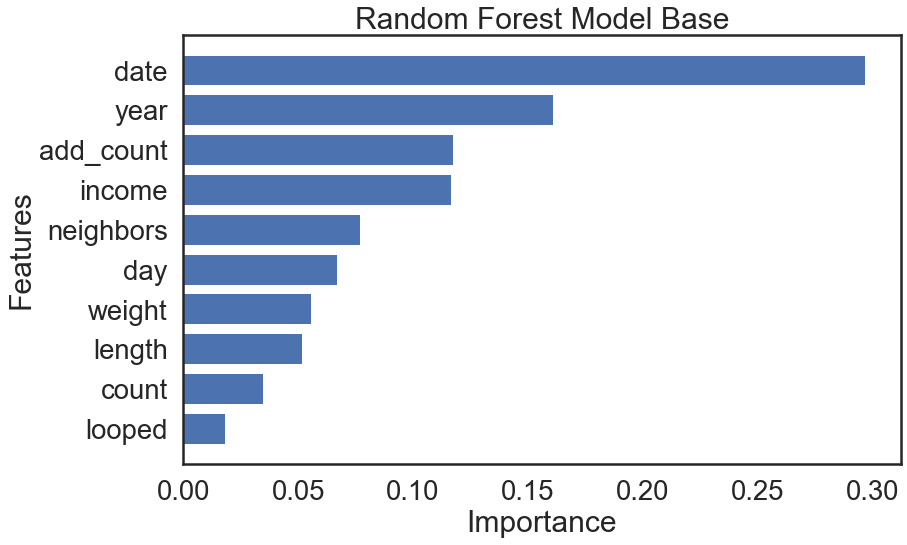

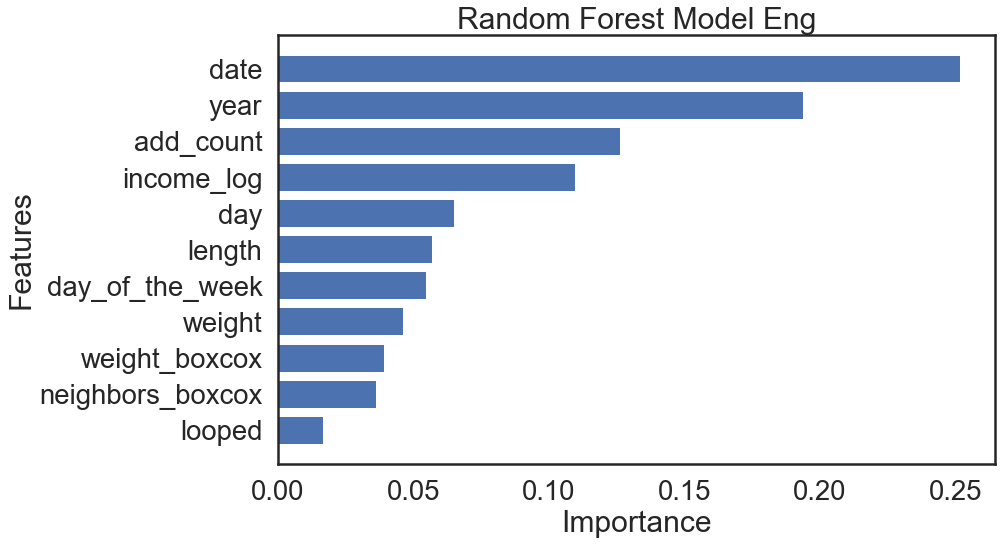

In [62]:
#Feature importance chart
model = RF_model_base, RF_model_eng
data = X_train_base, X_train_eng
name = ['Base','Eng']
for i,v in enumerate(model):
    fig, ax = plt.subplots()
    fig.tight_layout()
    fig.set_size_inches(15, 10)
    sns.set_context('poster',font_scale=1.25)
    coef = np.abs(v.best_estimator_[-1].feature_importances_)
    sorted_indices = np.argsort(coef)
    num_features = [j for j in range(data[i].shape[1])]
    columns = [data[i].columns[j] for j in sorted_indices]
    plt.barh(num_features, coef[sorted_indices]);
    plt.yticks(num_features, columns);
    plt.xlabel('Importance');
    plt.ylabel('Features');
    plt.title(f'Random Forest Model {name[i]}')
    plt.savefig(f'RF_Feature_Importance {name[i]}.png')

## Neural Network Model

In [63]:
#Baseline Train and Test
X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(transactions_df[['date','year','day','length','weight','count','looped','neighbors','income','add_count']], 
                                                    transactions_df['class'],
                                                    stratify = transactions_df['class'],
                                                    random_state = 24, 
                                                    test_size = 0.2)

X_train_base, X_val_base, y_train_base, y_val_base = train_test_split(X_train_base, y_train_base, test_size=0.25, random_state=24)

#Feature Engineered Train and Test
X_train_eng, X_test_eng, y_train_eng, y_test_eng = train_test_split(transactions_df[['date','year','day','length','weight','looped','add_count','weight_boxcox','neighbors_boxcox','income_log','day_of_the_week']], 
                                                    transactions_df['class'],
                                                    stratify = transactions_df['class'],
                                                    random_state = 24, 
                                                    test_size = 0.2)

X_train_eng, X_val_eng, y_train_eng, y_val_eng = train_test_split(X_train_eng, y_train_eng, test_size=0.25, random_state=24)

In [64]:
#Standardize the data for NN modelling
base = X_train_base, X_test_base, X_val_base
eng = X_train_eng, X_test_eng, X_val_eng

scaled_base = scale_data(base)
scaled_eng = scale_data(eng)

X_train_base_scaled, X_test_base_scaled, X_val_base_scaled = scaled_base
X_train_eng_scaled, X_test_eng_scaled, X_val_eng_scaled = scaled_eng

In [65]:
#Determine weights
negative, positive = np.bincount(transactions_df['class'])
total = negative + positive
weight_for_0 = (1 / negative) * (total / 2.0)
weight_for_1 = (1 / positive) * (total / 2.0)

#weight_for_0 = (1 / negative) * (total / 2)
#weight_for_1 = (1 / positive) * (total / 2)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.51
Weight for class 1: 21.88


In [66]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, InputLayer, Dropout, BatchNormalization
from sklearn.metrics import mean_squared_error
import math
import statsmodels.tsa.api as smt
from keras import optimizers
from keras import initializers
from keras.callbacks import EarlyStopping

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      tfa.metrics.F1Score(name='F1', num_classes=1, threshold=0.5),
      tfa.metrics.FBetaScore(name='F2', num_classes=1, beta=2.0, threshold=0.5),
      keras.metrics.BinaryAccuracy(name='accuracy', threshold=0.5),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

def make_model(df, metrics=None, weighted_metrics=None, output_bias=None):
    
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = keras.Sequential([
      keras.layers.Dense(100, activation='relu',input_shape=(df.shape[-1],)),
      keras.layers.BatchNormalization(),
      keras.layers.Dropout(0.3),
      keras.layers.Dense(50, activation='relu'),
      keras.layers.Dropout(0.3),
      keras.layers.Dense(25, activation='relu'),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
    ])
    model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=metrics)
    return model


### Baseline Model

In [67]:
#Initialize model
model_1_base = make_model(X_train_base_scaled, metrics=METRICS)
model_1_base.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               1100      
_________________________________________________________________
batch_normalization (BatchNo (None, 100)               400       
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 2

In [68]:
#Initialize model
model_1_eng = make_model(X_train_eng_scaled, metrics=METRICS)
model_1_eng.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 100)               1200      
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               400       
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

In [69]:
batch_size = 2000
epochs = 50

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_F2', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

results = model_1_base.evaluate(X_train_base_scaled, y_train_base, batch_size=batch_size, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.2497


In [70]:
batch_size = 2000
epochs = 50

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_F2', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

results = model_1_eng.evaluate(X_train_eng_scaled, y_train_eng, batch_size=batch_size, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.6421


In [71]:
#Calculate the inital bias so that the initial epochs are not just learning the imbalance of the classes
initial_bias = np.log([positive/negative])
initial_bias

array([-3.75537717])

In [72]:
model_2_base = make_model(X_train_base_scaled, metrics=METRICS, output_bias=initial_bias)
results_2_base = model_2_base.evaluate(X_train_base_scaled, y_train_base, batch_size=batch_size, verbose=0)
print("Loss: {:0.4f}".format(results_2_base[0]))
initial_weights_base = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model_2_base.save_weights(initial_weights_base)

Loss: 0.1068


In [73]:
model_2_eng = make_model(X_train_eng_scaled, metrics=METRICS, output_bias=initial_bias)
results_2_eng = model_2_eng.evaluate(X_train_eng_scaled, y_train_eng, batch_size=batch_size, verbose=0)
print("Loss: {:0.4f}".format(results_2_eng[0]))
initial_weights_eng = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model_2_eng.save_weights(initial_weights_eng)

Loss: 0.1081


In [103]:
zb_model_base = make_model(X_train_base_scaled)
zb_model_base.load_weights(initial_weights_base)
zb_model_base.layers[-1].bias.assign([0.0])
zero_bias_history_base = zb_model_base.fit(
    X_train_base_scaled,
    y_train_base,
    batch_size=batch_size,
    epochs=20,
    validation_data=(X_val_base_scaled, y_val_base), 
    verbose=0)

In [75]:
bh_model_base = make_model(X_train_base_scaled)
bh_model_base.load_weights(initial_weights_base)
bh_model_base.layers[-1].bias.assign(initial_bias)
biased_history_base = bh_model_base.fit(
    X_train_base_scaled,
    y_train_base,
    batch_size=batch_size,
    epochs=20,
    validation_data=(X_val_base_scaled, y_val_base), 
    verbose=0)

<Figure size 432x288 with 0 Axes>

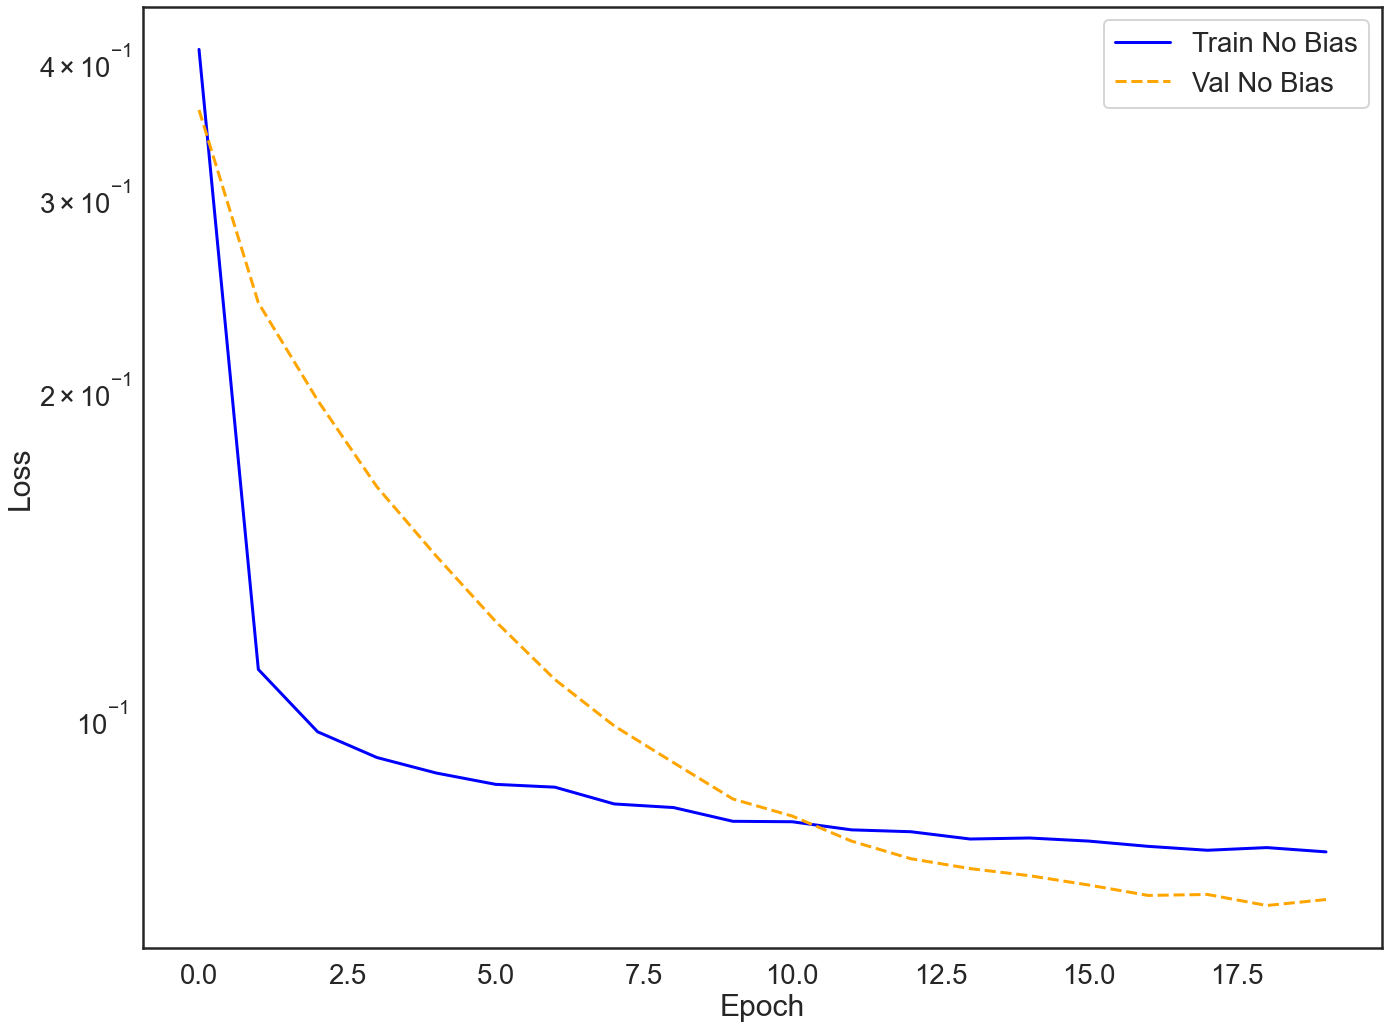

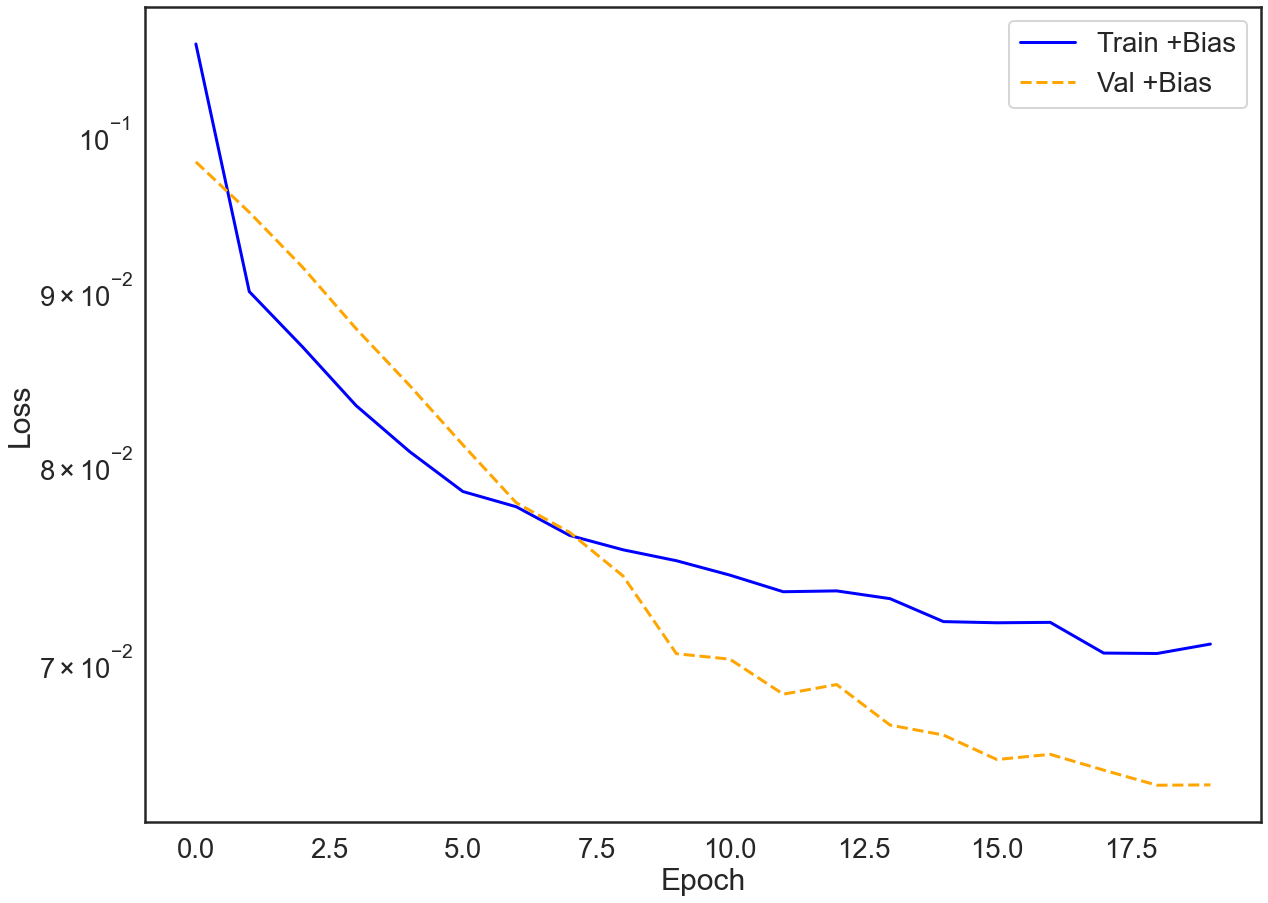

In [76]:
plot_loss(zero_bias_history_base, 'No Bias', 0)
plot_loss(biased_history_base, '+Bias', 1)

In [77]:
zb_model_eng = make_model(X_train_eng_scaled)
zb_model_eng.load_weights(initial_weights_eng)
zb_model_eng.layers[-1].bias.assign([0.0])
zero_bias_history_eng = zb_model_eng.fit(
    X_train_eng_scaled,
    y_train_eng,
    batch_size=batch_size,
    epochs=20,
    validation_data=(X_val_eng_scaled, y_val_eng), 
    verbose=0)

In [78]:
bh_model_eng = make_model(X_train_eng_scaled)
bh_model_eng.load_weights(initial_weights_eng)
bh_model_eng.layers[-1].bias.assign(initial_bias)
biased_history_eng = bh_model_eng.fit(
    X_train_eng_scaled,
    y_train_eng,
    batch_size=batch_size,
    epochs=20,
    validation_data=(X_val_eng_scaled, y_val_eng), 
    verbose=0)

<Figure size 432x288 with 0 Axes>

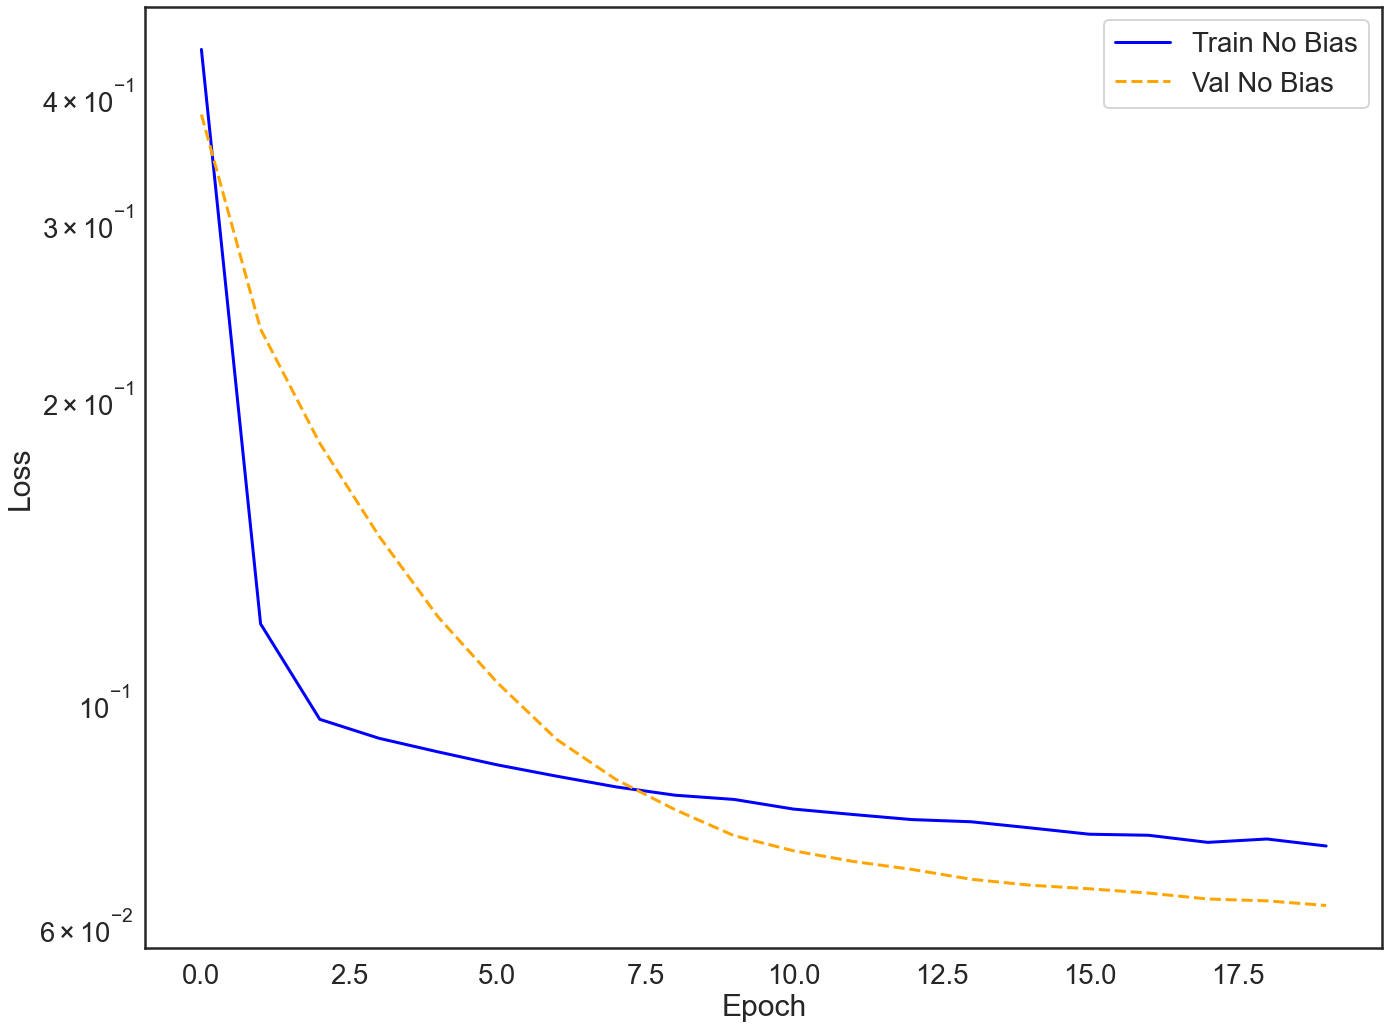

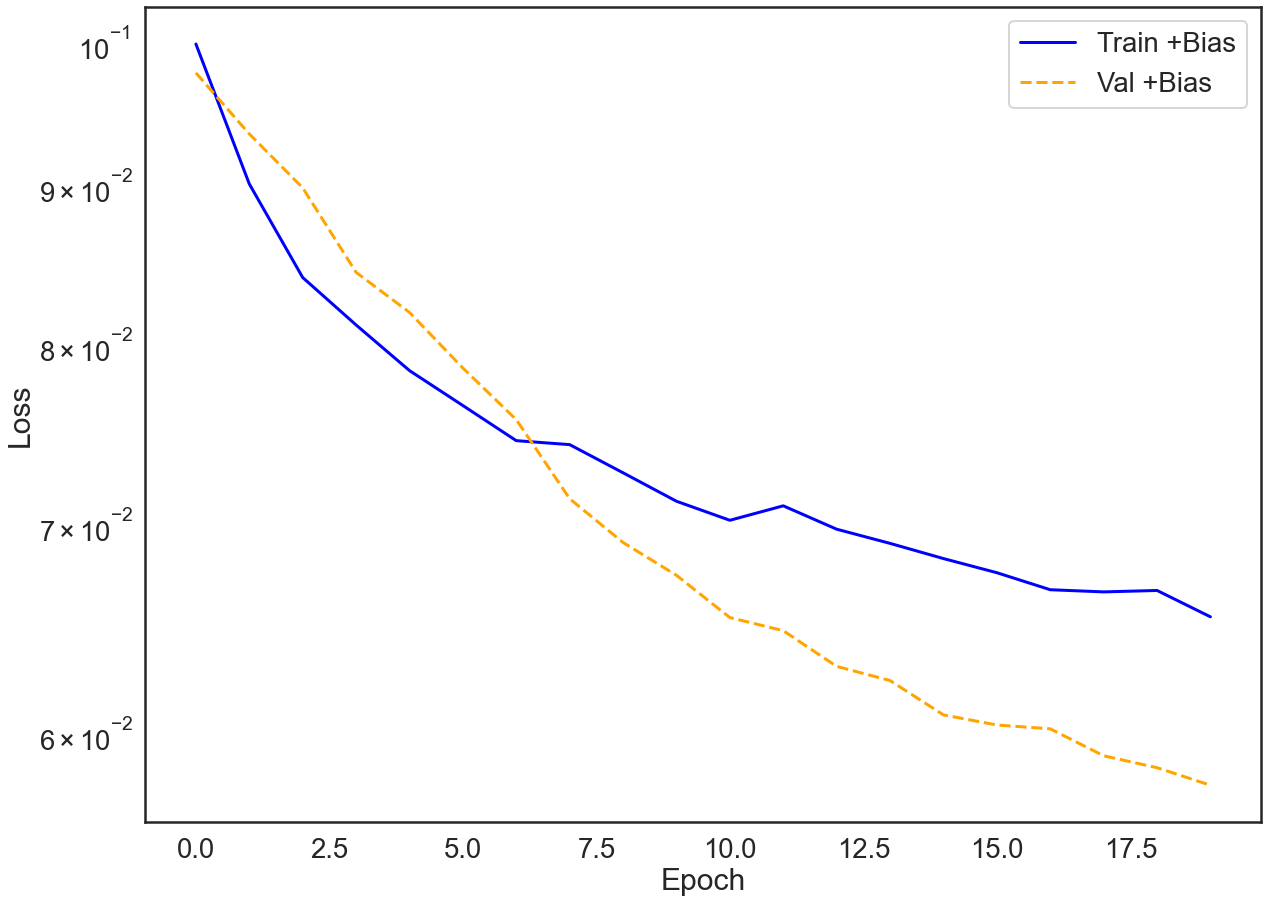

In [79]:
plot_loss(zero_bias_history_eng, 'No Bias', 0)
plot_loss(biased_history_eng, '+Bias', 1)

In [105]:
#Train the biased model
biased_model_base = make_model(X_train_base_scaled, metrics=METRICS)
biased_model_base.load_weights(initial_weights_base)
biased_model_base.layers[-1].bias.assign(initial_bias)
biased_history_base = biased_model_base.fit(
    X_train_base_scaled,
    y_train_base,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[early_stopping],
    validation_data=(X_val_base_scaled, y_val_base), 
    verbose=0)

Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping


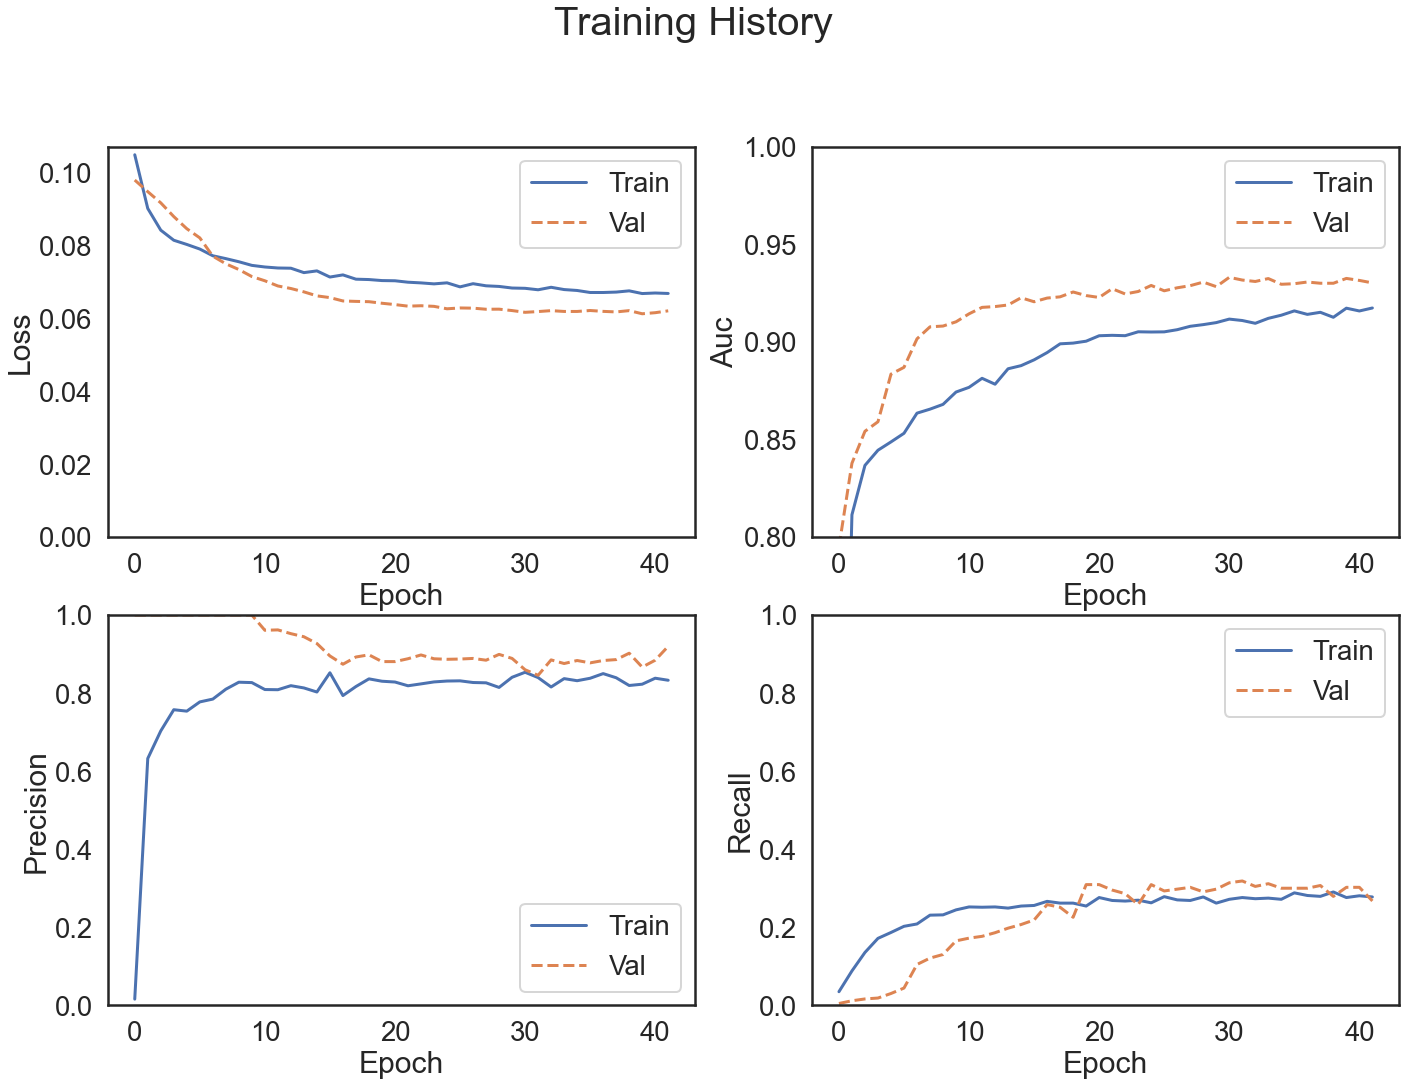

In [81]:
plot_metrics(biased_history_base, title='Biased_Base_TH')

In [82]:
#Train the biased model
biased_model_eng = make_model(X_train_eng_scaled, metrics=METRICS)
biased_model_eng.load_weights(initial_weights_eng)
biased_model_eng.layers[-1].bias.assign(initial_bias)
biased_history_eng = biased_model_eng.fit(
    X_train_eng_scaled,
    y_train_eng,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[early_stopping],
    validation_data=(X_val_eng_scaled, y_val_eng), 
    verbose=0)

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping


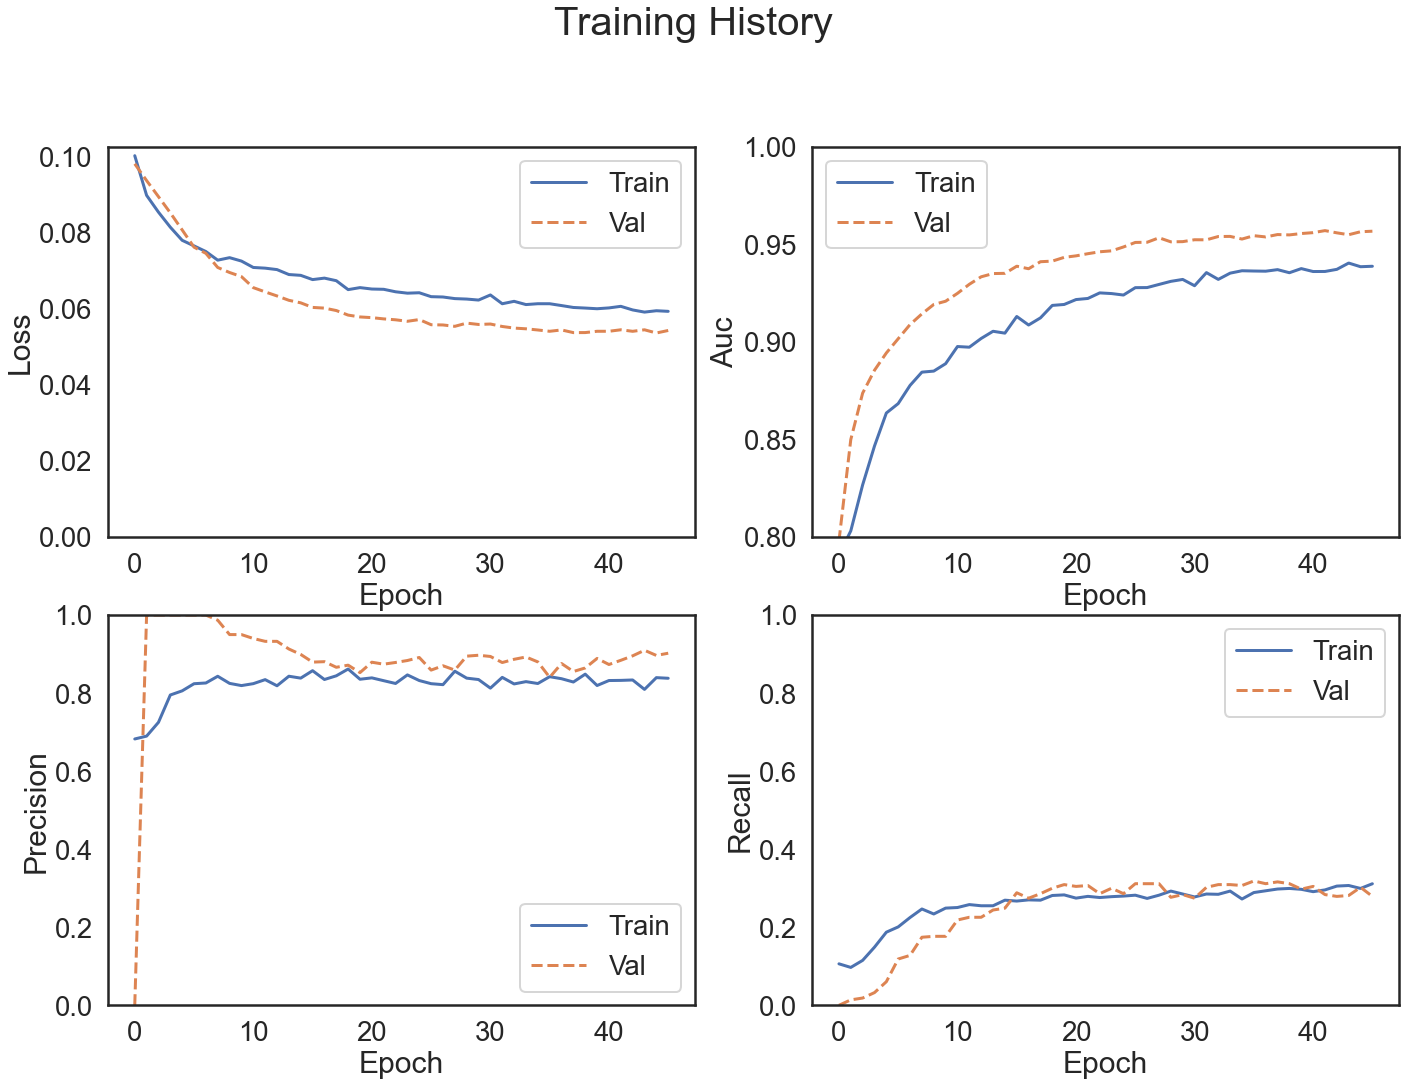

In [83]:
plot_metrics(biased_history_eng, title='Biased_Eng_TH')

In [86]:
make_table("Baseline Neural Net Base", y_test_base, biased_model_base.predict_classes(X_test_base_scaled, batch_size=batch_size), biased_model_base.predict(X_test_base_scaled, batch_size=batch_size), biased_history_base)
make_table("Baseline Neural Net Eng", y_test_eng, biased_model_eng.predict_classes(X_test_eng_scaled, batch_size=batch_size), biased_model_eng.predict(X_test_eng_scaled, batch_size=batch_size), biased_history_eng)

+--------------------------+----------+----------+----------+-----------+--------+----------+---------+
|        Model Name        | Accuracy | F1-Score | F2-Score | Precision | Recall | Log-loss | ROC_AUC |
+--------------------------+----------+----------+----------+-----------+--------+----------+---------+
| Baseline Neural Net Base |  0.982   |  0.416   |  0.320   |   0.833   | 0.278  |  0.594   |  0.917  |
+--------------------------+----------+----------+----------+-----------+--------+----------+---------+
+-------------------------+----------+----------+----------+-----------+--------+----------+---------+
|        Model Name       | Accuracy | F1-Score | F2-Score | Precision | Recall | Log-loss | ROC_AUC |
+-------------------------+----------+----------+----------+-----------+--------+----------+---------+
| Baseline Neural Net Eng |  0.983   |  0.454   |  0.356   |   0.838   | 0.312  |  0.587   |  0.939  |
+-------------------------+----------+----------+----------+--------

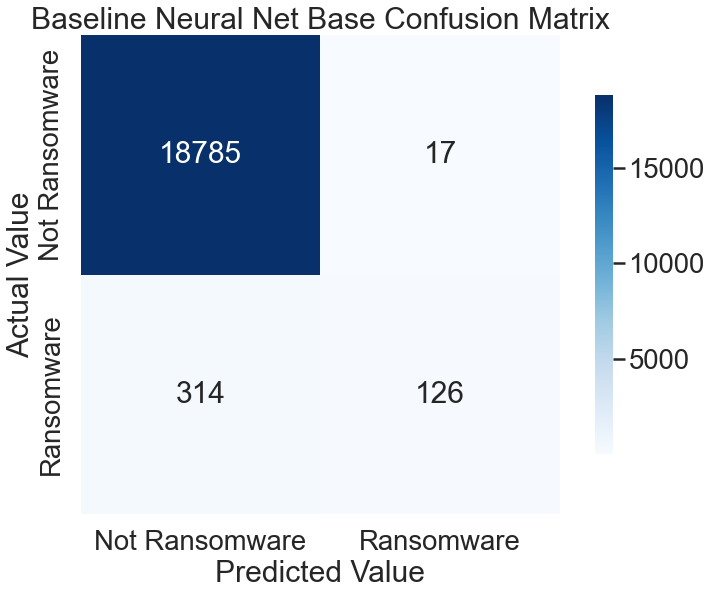

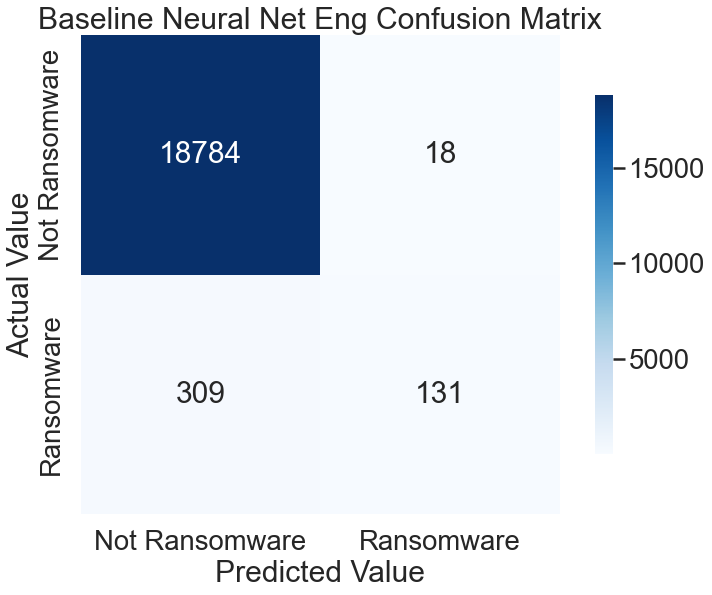

In [101]:
con_matrix(y_test_base, biased_model_base.predict_classes(X_test_base_scaled, batch_size=batch_size), 'Baseline Neural Net Base Confusion Matrix', name='Baseline_Neural_Net_Base_CM')
con_matrix(y_test_eng, biased_model_eng.predict_classes(X_test_eng_scaled, batch_size=batch_size), 'Baseline Neural Net Eng Confusion Matrix', name='Baseline_Neural_Net_Eng_CM')

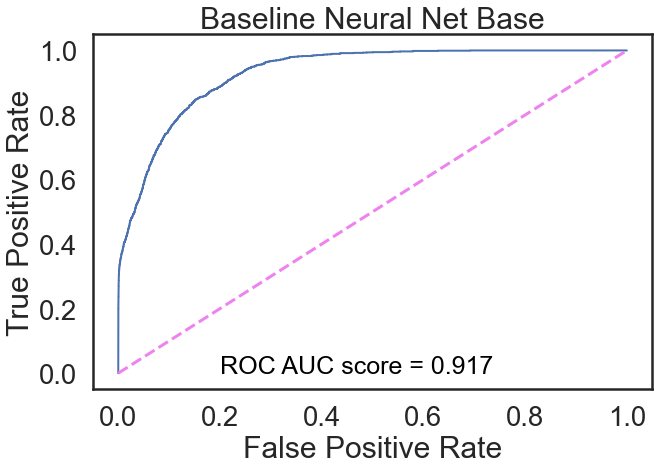

In [88]:
fpr, tpr, thresholds = roc_curve(y_train_base, biased_model_base.predict(X_train_base_scaled, batch_size=batch_size))
fig, ax = plt.subplots()
fig.tight_layout()
fig.set_size_inches(11.7, 8.27)
sns.set_context('poster',font_scale=1.25)
plt.plot(fpr, tpr, lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Baseline Neural Net Base')
plt.text(.2, 0, f'ROC AUC score = {"{:.3f}".format(biased_history_base.history["auc"][-1])}', horizontalalignment='left', size='small', color='black')
plt.savefig(f'Baseline Neural Net Base.png');

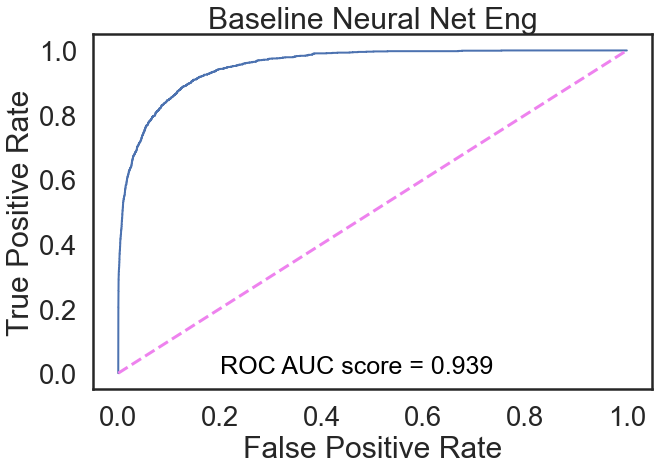

In [89]:
fpr, tpr, thresholds = roc_curve(y_train_eng, biased_model_eng.predict(X_train_eng_scaled, batch_size=batch_size))
fig, ax = plt.subplots()
fig.tight_layout()
fig.set_size_inches(11.7, 8.27)
sns.set_context('poster',font_scale=1.25)
plt.plot(fpr, tpr, lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Baseline Neural Net Eng')
plt.text(.2, 0, f'ROC AUC score = {"{:.3f}".format(biased_history_eng.history["auc"][-1])}', horizontalalignment='left', size='small', color='black')
plt.savefig(f'Baseline Neural Net Eng.png');

### Class Weighted Model

In [90]:
#Train the no biased model with weights
weighted_model_base = make_model(X_train_base_scaled, metrics=METRICS)
weighted_model_base.load_weights(initial_weights_base)
weighted_model_base.layers[-1].bias.assign(initial_bias)
weighted_history_base = weighted_model_base.fit(
    X_train_base_scaled,
    y_train_base,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[early_stopping],
    validation_data=(X_val_base_scaled, y_val_base), 
    verbose=0,
    class_weight=class_weight)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping


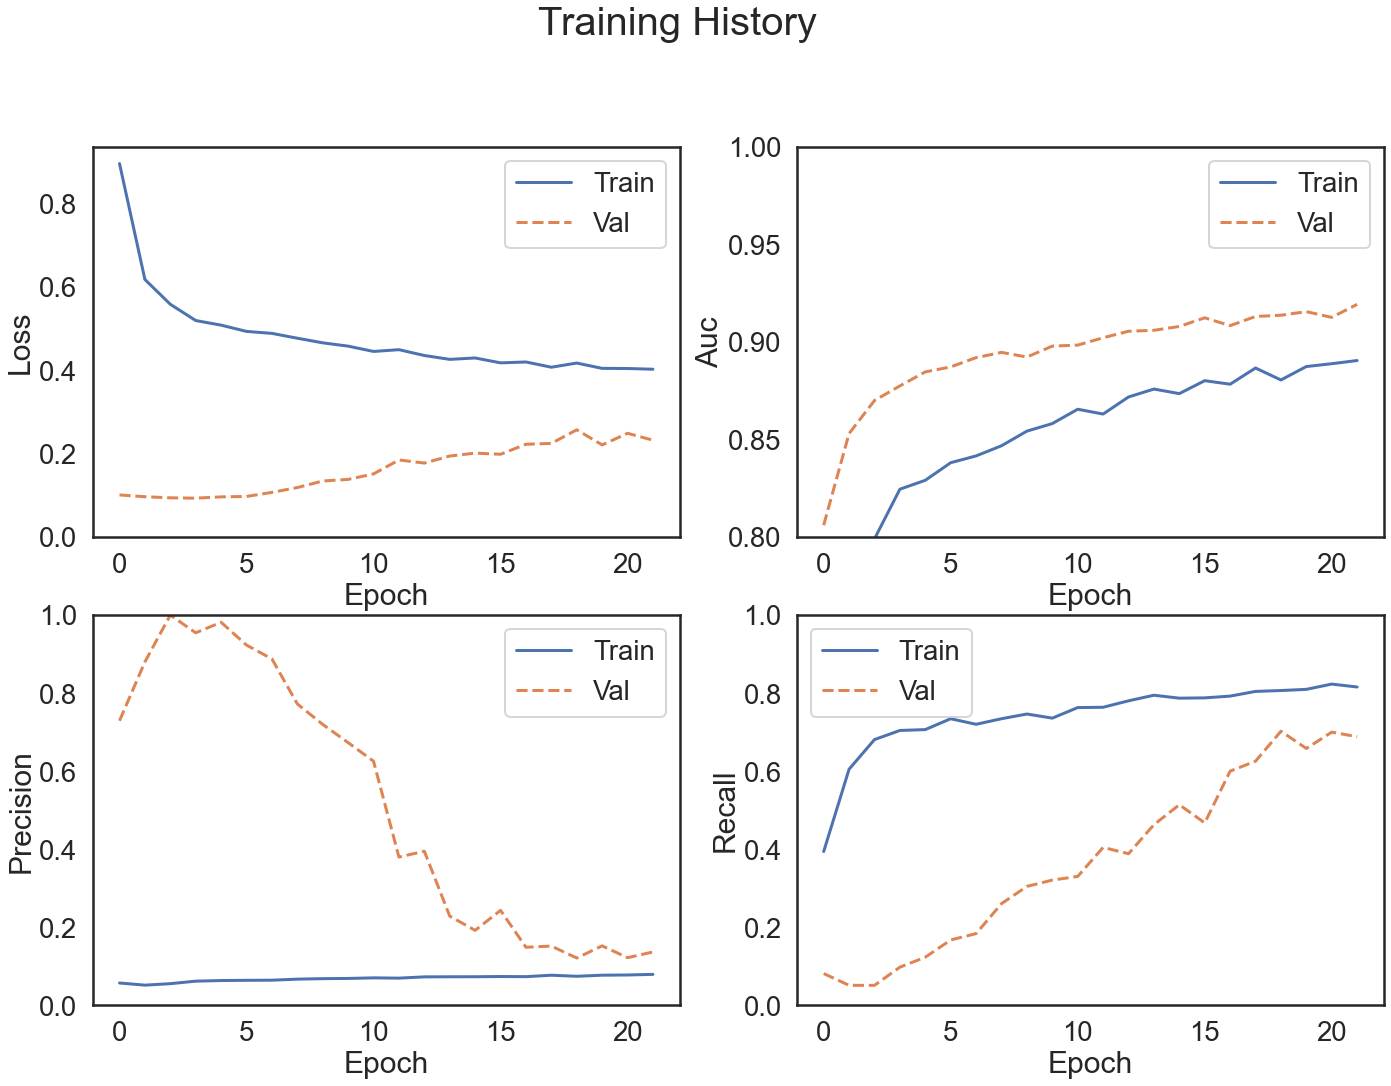

In [91]:
plot_metrics(weighted_history_base, title='Weighted_Biased_Base_TH')

In [92]:
#Train the no biased model with weights
weighted_model_eng = make_model(X_train_eng_scaled, metrics=METRICS)
weighted_model_eng.load_weights(initial_weights_eng)
weighted_model_eng.layers[-1].bias.assign(initial_bias)
weighted_history_eng = weighted_model_eng.fit(
    X_train_eng_scaled,
    y_train_eng,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[early_stopping],
    validation_data=(X_val_eng_scaled, y_val_eng), 
    verbose=0,
    class_weight=class_weight)

Restoring model weights from the end of the best epoch.
Epoch 00039: early stopping


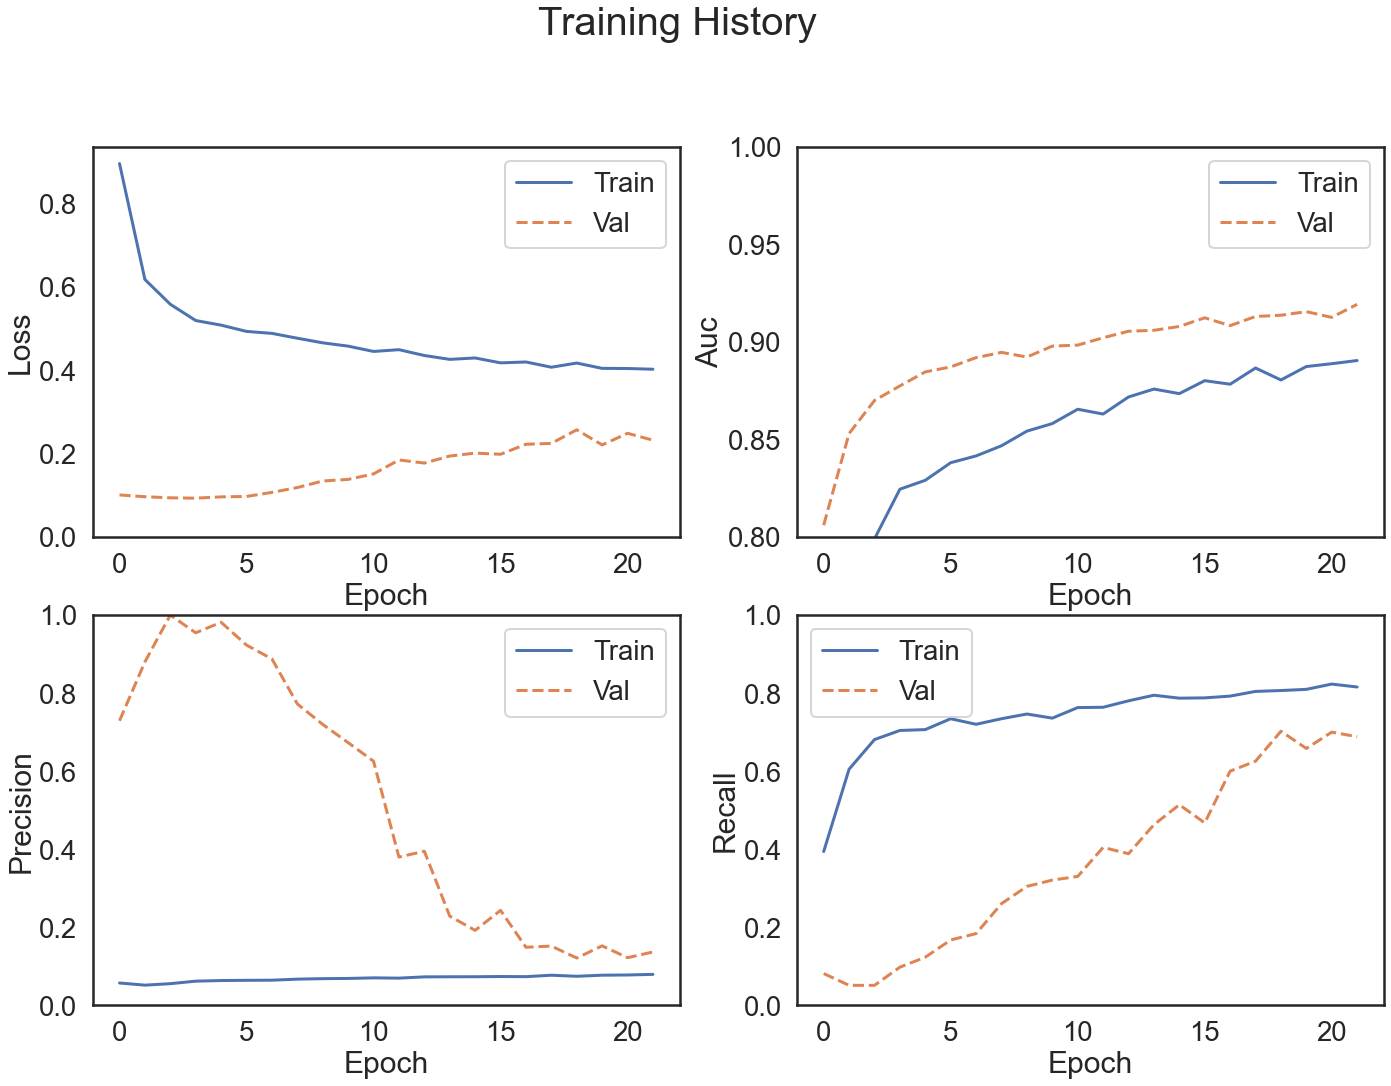

In [93]:
plot_metrics(weighted_history_base, title='Weighted_Biased_Eng_TH')

In [94]:
make_table("Weighted Neural Net Base", y_test_base, weighted_model_base.predict_classes(X_test_base_scaled, batch_size=batch_size), weighted_model_base.predict(X_test_base_scaled, batch_size=batch_size), weighted_history_base)
make_table("Weighted Neural Net Eng", y_test_eng, weighted_model_eng.predict_classes(X_test_eng_scaled, batch_size=batch_size), weighted_model_eng.predict(X_test_eng_scaled, batch_size=batch_size), weighted_history_eng)

+--------------------------+----------+----------+----------+-----------+--------+----------+---------+
|        Model Name        | Accuracy | F1-Score | F2-Score | Precision | Recall | Log-loss | ROC_AUC |
+--------------------------+----------+----------+----------+-----------+--------+----------+---------+
| Weighted Neural Net Base |  0.778   |  0.144   |  0.285   |   0.079   | 0.816  |  0.840   |  0.890  |
+--------------------------+----------+----------+----------+-----------+--------+----------+---------+
+-------------------------+----------+----------+----------+-----------+--------+----------+---------+
|        Model Name       | Accuracy | F1-Score | F2-Score | Precision | Recall | Log-loss | ROC_AUC |
+-------------------------+----------+----------+----------+-----------+--------+----------+---------+
| Weighted Neural Net Eng |  0.831   |  0.191   |  0.359   |   0.107   | 0.865  |  2.811   |  0.935  |
+-------------------------+----------+----------+----------+--------

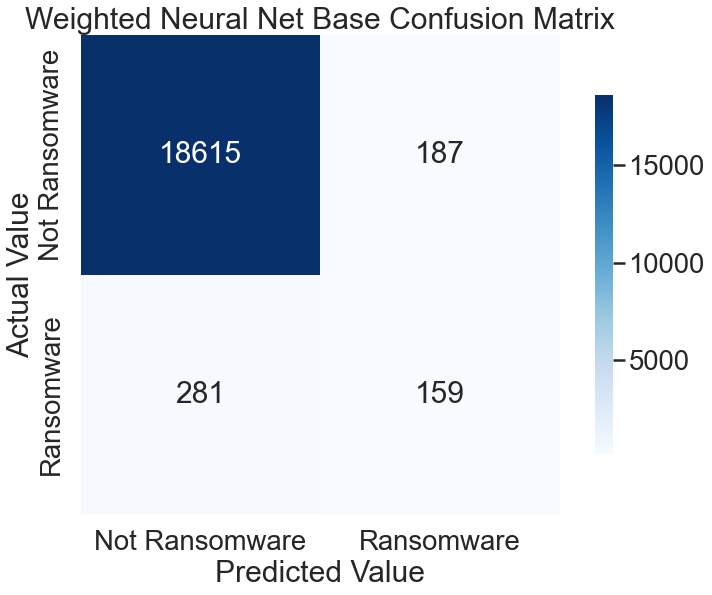

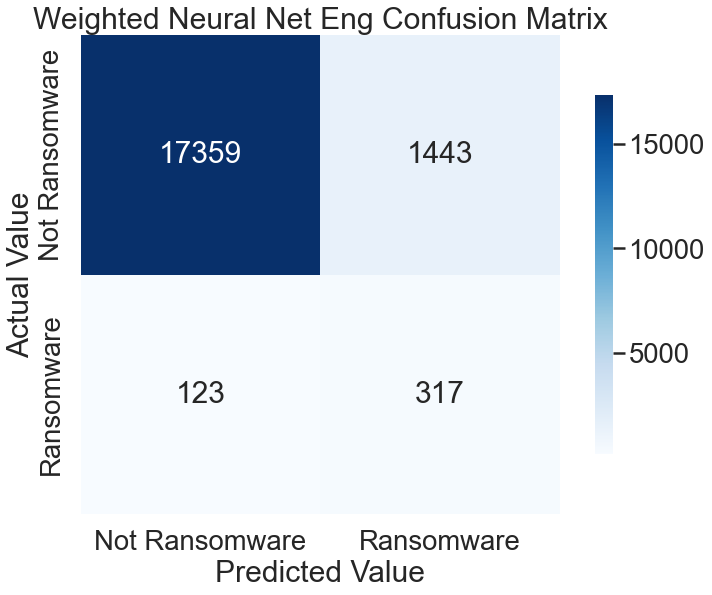

In [95]:
con_matrix(y_test_base, weighted_model_base.predict_classes(X_test_base_scaled, batch_size=batch_size), 'Weighted Neural Net Base Confusion Matrix', name='Weighted_NN_CM_Base')
con_matrix(y_test_eng, weighted_model_eng.predict_classes(X_test_eng_scaled, batch_size=batch_size), 'Weighted Neural Net Eng Confusion Matrix', name='Weighted_NN_CM_Eng')

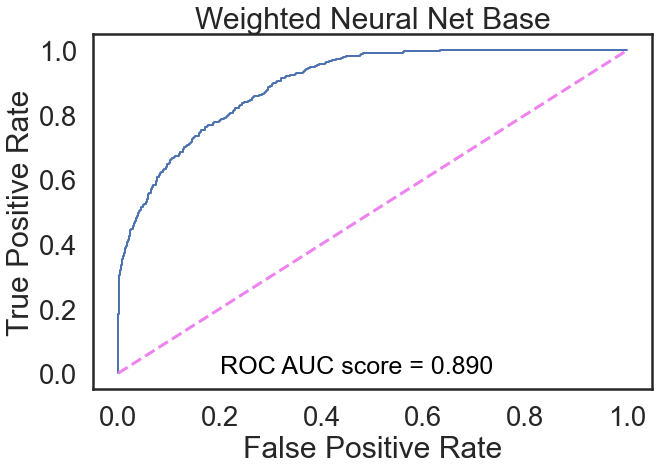

In [96]:
fpr, tpr, thresholds = roc_curve(y_test_base, weighted_model_base.predict(X_test_base_scaled, batch_size=batch_size))
fig, ax = plt.subplots()
fig.tight_layout()
fig.set_size_inches(11.7, 8.27)
sns.set_context('poster',font_scale=1.25)
plt.plot(fpr, tpr, lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Weighted Neural Net Base')
plt.text(.2, 0, f'ROC AUC score = {"{:.3f}".format(weighted_history_base.history["auc"][-1])}', horizontalalignment='left', size='small', color='black')
plt.savefig(f'Weighted Neural Net Base.png');

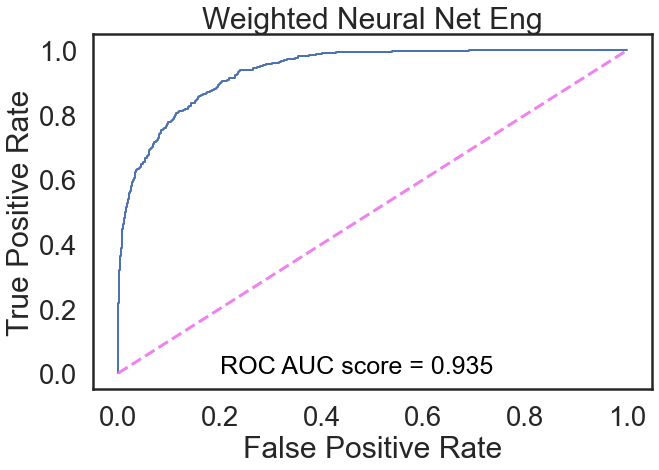

In [97]:
fpr, tpr, thresholds = roc_curve(y_test_eng, weighted_model_eng.predict(X_test_eng_scaled, batch_size=batch_size))
fig, ax = plt.subplots()
fig.tight_layout()
fig.set_size_inches(11.7, 8.27)
sns.set_context('poster',font_scale=1.25)
plt.plot(fpr, tpr, lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Weighted Neural Net Eng')
plt.text(.2, 0, f'ROC AUC score = {"{:.3f}".format(weighted_history_eng.history["auc"][-1])}', horizontalalignment='left', size='small', color='black')
plt.savefig(f'Weighted Neural Net Eng.png');